In [1]:
## Initially, Read in 1 Chromosome and Test Processing Pipeline

import os
import gzip
import pandas as pd

# === USER INPUTS ===
PHENO_PATH = "ImmPort_URECA_Cross_Black.csv"  # your attached phenotype subset
PHENO_ID_COL = "id"                           # column in phenotype file with sample IDs
VCF_INPUT = "URECA.WGS.annotated.recoded.chr22.vcf.gz"  # chromosome 22, gzipped
OUT_CSV = "chr22.filtered_by_subset.csv"
OUT_VCF = "chr22.filtered_by_subset.vcf"
DROP_ROWS_ALL_MISSING = False  # set True to drop variants where all kept samples are "./."
# ====================

# 1) Load the phenotype subset IDs--Here we are subsetting to the black population
pheno = pd.read_csv(PHENO_PATH)
subset_ids = (
    pheno[PHENO_ID_COL]
    .astype(str)
    .str.strip()
    .tolist()
)
subset_ids_set = set(subset_ids)
print(f"[info] Loaded {len(subset_ids_set)} unique IDs from {PHENO_PATH}")

if not os.path.exists(VCF_INPUT):
    raise FileNotFoundError(f"Input VCF not found: {VCF_INPUT}")

meta_lines = []
header_parts = None
kept_samples = []
keep_col_idxs = None
base_col_count = 9  # VCF fixed columns

# 2) First pass: read header/meta, decide which samples to keep
with gzip.open(VCF_INPUT, "rt") as f:
    for line in f:
        if line.startswith("##"):
            meta_lines.append(line.rstrip("\n"))
            continue
        if line.startswith("#CHROM"):
            header_parts = line.rstrip("\n").split("\t")
            all_samples = header_parts[base_col_count:]
            kept_samples = [s for s in all_samples if s in subset_ids_set]

            found_set = set(kept_samples)
            missing = sorted(list(subset_ids_set - found_set))
            if missing:
                print(f"[warn] {len(missing)} subset ID(s) not present in VCF header, e.g.: {missing[:10]}")
            if not kept_samples:
                raise RuntimeError("No overlapping sample IDs between phenotype subset and VCF.")

            # indices to keep = fixed 9 + selected samples
            sample_name_to_idx = {s: base_col_count + i for i, s in enumerate(all_samples)}
            keep_col_idxs = list(range(base_col_count)) + [sample_name_to_idx[s] for s in kept_samples]
            break

if header_parts is None:
    raise RuntimeError("VCF header (#CHROM line) not found in input.")

filtered_header = header_parts[:base_col_count] + kept_samples

def is_missing(gt_field: str) -> bool:
    # genotype (before ':') is missing if "./." or ".|." or "."
    if gt_field is None:
        return True
    gt = gt_field.split(":", 1)[0] if gt_field else ""
    return gt in {"./.", ".|.", "."}

# 3) Second pass: stream data, collect filtered rows; also write VCF as we go
filtered_rows = []
n_rows_in = 0
n_rows_out = 0

with gzip.open(VCF_INPUT, "rt") as fin, open(OUT_VCF, "w") as vout:
    # write meta lines to output VCF
    for ml in meta_lines:
        vout.write(ml + "\n")
    # write filtered header to output VCF
    vout.write("\t".join(filtered_header) + "\n")

    # move file pointer to first data line (after #CHROM)
    for line in fin:
        if line.startswith("#CHROM"):
            break

    for line in fin:
        if not line or line.startswith("#"):
            continue
        n_rows_in += 1
        parts = line.rstrip("\n").split("\t")
        row = [parts[i] for i in keep_col_idxs]

        if DROP_ROWS_ALL_MISSING and len(row) > base_col_count:
            sample_fields = row[base_col_count:]
            if all(is_missing(sf) for sf in sample_fields):
                continue  # skip variant

        # keep for CSV
        filtered_rows.append(row)
        n_rows_out += 1

        # write to VCF
        vout.write("\t".join(row) + "\n")

print(f"[done] Input variants read: {n_rows_in}")
print(f"[done] Output variants written: {n_rows_out}")
print(f"[done] Kept {len(kept_samples)} sample(s). VCF saved to: {OUT_VCF}")

#4) Save CSV
vcf_df = pd.DataFrame(filtered_rows, columns=filtered_header)
vcf_df.to_csv(OUT_CSV, index=False)
print(f"[done] CSV saved to: {OUT_CSV}")

# (Optional) quick peek
vcf_df.head()


[info] Loaded 119 unique IDs from ImmPort_URECA_Cross_Black.csv
[done] Input variants read: 1186020
[done] Output variants written: 1186020
[done] Kept 119 sample(s). VCF saved to: chr22.filtered_by_subset.vcf
[done] CSV saved to: chr22.filtered_by_subset.csv


,#CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,8119_45f3,...,1ce6_4a8b,8da2_4ffa,16a0_4f5a,aacf_4181,4438_4db6,19c1_493c,1455_4f52,d084_4cd9,9e45_40b0,0820_4702
0,chr22,10510105,rs1325858619,T,A,620.55,VQSRTrancheSNP99.95to100.00;DP10.GQ20.nocalls_0.1,AC=12;AF=0.023;AN=284;DP=664;ExcessHet=0;FS=0;...,GT:AD:DP:GQ:PL,"./.:0,0:0:.:0,0,0",...,"0/0:1,0:1:3:0,3,14","./.:0,0:0:.:0,0,0","./.:0,0:0:.:0,0,0","0/0:6,0:6:18:0,18,209","0/0:4,0:4:12:0,12,129","./.:0,0:0:.:0,0,0","./.:0,0:0:.:0,0,0","./.:0,0:0:.:0,0,0","./.:0,0:0:.:0,0,0","./.:0,0:0:.:0,0,0"
1,chr22,10510161,.,T,A,44.49,VQSRTrancheSNP99.90to99.95;DP10.GQ20.nocalls_0.1,AC=2;AF=0.002985;AN=334;DP=972;ExcessHet=0.003...,GT:AD:DP:GQ:PL,"./.:0,0:0:.:0,0,0",...,"0/0:1,0:1:3:0,3,14","./.:0,0:0:.:0,0,0","./.:0,0:0:.:0,0,0","0/0:5,0:5:15:0,15,164","0/0:7,0:7:21:0,21,223","./.:0,0:0:.:0,0,0","./.:0,0:0:.:0,0,0","./.:0,0:0:.:0,0,0","./.:0,0:0:.:0,0,0","./.:0,0:0:.:0,0,0"
2,chr22,10510212,rs1452389754,A,T,353.84,VQSRTrancheSNP99.90to99.95;DP10.GQ20.nocalls_0.1,AC=6;AF=0.014;AN=428;BaseQRankSum=0.549;DP=170...,GT:AD:DP:GQ:PL,"./.:0,0:0:.:0,0,0",...,"0/0:1,0:1:3:0,3,14","./.:0,0:0:.:0,0,0","./.:0,0:0:.:0,0,0","0/0:7,0:7:21:0,21,223","0/0:7,0:7:21:0,21,223","./.:1,0:1:.:0,0,0","./.:0,0:0:.:0,0,0","./.:0,0:0:.:0,0,0","./.:0,0:0:.:0,0,0","0/0:1,0:1:3:0,3,35"
3,chr22,10510292,rs1304841723,T,C,141.69,VQSRTrancheSNP99.90to99.95;DP10.GQ20.nocalls_0.1,AC=2;AF=0.00335;AN=592;BaseQRankSum=0;DP=2205;...,GT:AD:DP:GQ:PL,"./.:0,0:0:.:0,0,0",...,"./.:0,0:0:.:0,0,0","./.:0,0:0:.:0,0,0","./.:0,0:0:.:0,0,0","0/0:4,0:4:12:0,12,139","0/0:2,0:2:6:0,6,70","0/0:1,0:1:3:0,3,35","./.:0,0:0:.:0,0,0","0/0:1,0:1:3:0,3,14","./.:0,0:0:.:0,0,0","0/0:2,0:2:6:0,6,49"
4,chr22,10510338,.,C,T,457.42,VQSRTrancheSNP99.90to99.95;DP10.GQ20.nocalls_0.1,AC=0;AF=0.0009434;AN=528;BaseQRankSum=-0.811;D...,GT:AD:DP:GQ:PGT:PID:PL:PS,"./.:0,0:0:.:.:.:0,0,0:.",...,"./.:0,0:0:.:.:.:0,0,0:.","./.:0,0:0:.:.:.:0,0,0:.","./.:0,0:0:.:.:.:0,0,0:.","0/0:8,0:8:24:.:.:0,24,278:.","0/0:7,0:7:21:.:.:0,21,223:.","./.:0,0:0:.:.:.:0,0,0:.","./.:0,0:0:.:.:.:0,0,0:.","0/0:1,0:1:3:.:.:0,3,14:.","./.:0,0:0:.:.:.:0,0,0:.","0/0:1,0:1:3:.:.:0,3,35:."


In [2]:
# Subset data to only black subjects, and QC VCF data
import os
import pandas as pd

# ========= User inputs =========
IN_CSV = "chr22.filtered_by_subset.csv"       # input from your earlier step
IN_VCF = "chr22.filtered_by_subset.vcf"       # for copying meta/header lines
OUT_CSV = "chr22.processed.filtered.csv"
OUT_VCF = "chr22.processed.filtered.vcf"

QUAL_MIN = 70
DP_MIN = 10                  # used only when DP is present and numeric
MAF_MIN = 0.05               # keep variants with MAF >= 0.05
# ===============================


# ---------- helpers ----------
def snp_and_biallelic(ref: str, alt: str) -> bool:
    """True if single-ALT biallelic SNP (REF len 1, ALT len 1, no commas)."""
    if not isinstance(ref, str) or not isinstance(alt, str):
        return False
    if "," in alt:
        return False
    return len(ref) == 1 and len(alt) == 1

def is_callable_geno(sample_field: str, dp_idx: int | None) -> bool:
    """
    A genotype (per-sample field) is 'callable' if:
      - GT is present (not ./., .|., or .), AND
      - if DP exists and is numeric, DP > DP_MIN.
    If DP is absent/missing/non-numeric, we DO NOT penalize; GT is enough.
    """
    if not isinstance(sample_field, str) or sample_field in ("", "."):
        return False

    toks = sample_field.split(":")
    gt = toks[0] if toks else ""
    if gt in {"./.", ".|.", "."}:
        return False

    if dp_idx is not None:
        if dp_idx >= len(toks):
            return True  # DP field missing for this sample -> don't penalize
        dp_raw = toks[dp_idx]
        if dp_raw in (".", ""):
            return True  # absent DP -> don't penalize
        try:
            dp = int(dp_raw)
        except Exception:
            return True  # non-numeric DP -> don't penalize
        return dp > DP_MIN

    # No DP in FORMAT -> rely on GT only
    return True

def maf_from_row(row: pd.Series, sample_cols: list[str]) -> float | None:
    """
    Compute MAF for a biallelic site using callable genotypes only.
    Counts alleles from GT; skips alleles other than 0/1; respects DP when present.
    Returns None if no callable alleles.
    """
    fmt = str(row["FORMAT"]) if "FORMAT" in row.index else ""
    fmt_keys = fmt.split(":") if fmt else []
    dp_idx = fmt_keys.index("DP") if "DP" in fmt_keys else None

    ac = 0  # ALT allele count
    an = 0  # total allele count

    for s in sample_cols:
        field = row[s]
        if not is_callable_geno(field, dp_idx):
            continue
        gt = str(field).split(":", 1)[0]
        sep = "/" if "/" in gt else ("|" if "|" in gt else None)
        if sep is None:
            # haploid or malformed -> skip
            continue
        alleles = gt.split(sep)
        for a in alleles:
            if a in ("0", "1"):
                an += 1
                if a == "1":
                    ac += 1
            # ignore others

    if an == 0:
        return None
    p_alt = ac / an
    return min(p_alt, 1 - p_alt)

def log_step(name: str, before_df: pd.DataFrame, after_df: pd.DataFrame, log_list: list, extra: dict | None = None):
    info = {
        "step": name,
        "variants_before": before_df.shape[0],
        "variants_after":  after_df.shape[0],
        "variants_removed": before_df.shape[0] - after_df.shape[0],
        "samples_before": max(len(before_df.columns) - 9, 0),
        "samples_after":  max(len(after_df.columns) - 9, 0),
        "samples_removed": max(len(before_df.columns) - 9, 0) - max(len(after_df.columns) - 9, 0),
    }
    if extra:
        info.update(extra)
    log_list.append(info)
    print(f"[{name}] variants: {info['variants_before']} -> {info['variants_after']} "
          f"(−{info['variants_removed']}); samples: {info['samples_before']} -> {info['samples_after']} "
          f"(−{info['samples_removed']})")


# ---------- 0) Load ----------
vcf_df = pd.read_csv(IN_CSV, low_memory=False)
if vcf_df.shape[1] < 10:
    raise RuntimeError(
        "Parsed CSV has fewer than 10 columns. Expected fixed 9 VCF columns + FORMAT + sample columns.\n"
        "Check that the input CSV came from the subset step that kept FORMAT+samples."
    )

fixed_cols = list(vcf_df.columns[:9])   # #CHROM POS ID REF ALT QUAL FILTER INFO FORMAT
sample_cols = list(vcf_df.columns[9:])
log = []

# ---------- 1) Drop multiallelic (max-alleles = 2) ----------
step1 = vcf_df[~vcf_df["ALT"].astype(str).str.contains(",", na=True)].copy()
log_step("drop_multiallelics", vcf_df, step1, log)

# ---------- 2) Keep SNPs only ----------
mask_snp = step1.apply(lambda r: snp_and_biallelic(str(r["REF"]), str(r["ALT"])), axis=1)
step2 = step1[mask_snp].copy()
log_step("keep_SNPs_only", step1, step2, log)

# ---------- 3) Drop unannotated variants (ID == '.' or missing) ----------
mask_annot = step2["ID"].notna() & step2["ID"].astype(str).str.strip().ne(".")
step2_annot = step2[mask_annot].copy()
log_step("drop_unannotated_IDs", step2, step2_annot, log, extra={"criterion": "ID != '.'"})

# ---------- 4) QUAL >= 70 ----------
step2_annot["QUAL"] = pd.to_numeric(step2_annot["QUAL"], errors="coerce")
step3 = step2_annot[step2_annot["QUAL"] >= QUAL_MIN].copy()
log_step(f"QUAL>={QUAL_MIN}", step2_annot, step3, log)

# ---------- 5) MAF >= 0.05 (computed from callable GTs; DP>10 if DP exists) ----------
cur = step3
sample_cols = list(cur.columns[9:])
if cur.shape[0] == 0 or len(sample_cols) == 0:
    step4 = cur.copy()
else:
    mafs = cur.apply(lambda r: maf_from_row(r, sample_cols), axis=1)
    step4 = cur[(mafs.notna()) & (mafs >= MAF_MIN)].copy()
log_step(f"keep_MAF>={MAF_MIN}", cur, step4, log)

final_df = step4

# ---------- 6) Save CSV ----------
final_df.to_csv(OUT_CSV, index=False)
print(f"[save] CSV -> {OUT_CSV} (variants={final_df.shape[0]}, samples={len(final_df.columns)-9})")

# ---------- 7) Save VCF ----------
if not os.path.exists(IN_VCF):
    raise FileNotFoundError(f"Could not find {IN_VCF} to copy meta/header for VCF output.")

meta_lines = []
with open(IN_VCF, "r") as f:
    for line in f:
        if line.startswith("##"):
            meta_lines.append(line.rstrip("\n"))
        elif line.startswith("#CHROM"):
            break

kept_header = list(final_df.columns[:9]) + list(final_df.columns[9:])
with open(OUT_VCF, "w") as vout:
    for ml in meta_lines:
        vout.write(ml + "\n")
    vout.write("\t".join(kept_header) + "\n")
    for _, row in final_df.iterrows():
        vout.write("\t".join(str(row[col]) for col in kept_header) + "\n")

print(f"[save] VCF -> {OUT_VCF} (variants={final_df.shape[0]}, samples={len(final_df.columns)-9})")

# ---------- 8) Summary ----------
summary = pd.DataFrame(log)
print("\n=== QC Summary ===")
print(summary.to_string(index=False))



[drop_multiallelics] variants: 1186020 -> 1059892 (−126128); samples: 119 -> 119 (−0)
[keep_SNPs_only] variants: 1059892 -> 973431 (−86461); samples: 119 -> 119 (−0)
[drop_unannotated_IDs] variants: 973431 -> 928432 (−44999); samples: 119 -> 119 (−0)
[QUAL>=70] variants: 928432 -> 904827 (−23605); samples: 119 -> 119 (−0)
[keep_MAF>=0.05] variants: 904827 -> 155154 (−749673); samples: 119 -> 119 (−0)
[save] CSV -> chr22.processed.filtered.csv (variants=155154, samples=119)
[save] VCF -> chr22.processed.filtered.vcf (variants=155154, samples=119)

=== QC Summary ===
                step  variants_before  variants_after  variants_removed  samples_before  samples_after  samples_removed criterion
  drop_multiallelics          1186020         1059892            126128             119            119                0       NaN
      keep_SNPs_only          1059892          973431             86461             119            119                0       NaN
drop_unannotated_IDs           973431 

In [3]:
# --- Annotate rsIDs with functional consequences (CSQ) via Ensembl VEP REST API ---

import os
import time
import json
import requests
import pandas as pd
from typing import Iterable, List, Dict, Any

# ========= Inputs/Outputs =========
IN_PROCESSED_CSV = "chr22.processed.filtered.csv"
IN_PROCESSED_VCF = "chr22.processed.filtered.vcf"   # to reuse header/meta lines
OUT_ANNOTATED_CSV = "chr22.processed.filtered.vep.csv"
OUT_ANNOTATED_VCF = "chr22.processed.filtered.vep.vcf"
# ==================================

VEP_URL = "https://rest.ensembl.org/vep/human/id"
BATCH_SIZE = 200          # Ensembl handles a few hundred IDs per POST safely
MAX_RETRIES = 5
BACKOFF_SECS = 2.0        # exponential backoff base

def batched(iterable: Iterable[Any], n: int) -> Iterable[List[Any]]:
    """Yield lists of size n from iterable."""
    batch = []
    for item in iterable:
        batch.append(item)
        if len(batch) == n:
            yield batch
            batch = []
    if batch:
        yield batch

def vep_query_rsids(rsids: List[str]) -> Dict[str, dict]:
    """
    Query Ensembl VEP REST API for a list of rsIDs.
    Returns a mapping rsid -> VEP result (first match).
    """
    headers = {"Content-Type": "application/json", "Accept": "application/json"}
    payload = {"ids": rsids}
    for attempt in range(1, MAX_RETRIES + 1):
        try:
            r = requests.post(VEP_URL, headers=headers, data=json.dumps(payload), timeout=60)
            if r.status_code == 429:
                # Rate limited — honor Retry-After if present
                wait = float(r.headers.get("Retry-After", BACKOFF_SECS * attempt))
                time.sleep(wait)
                continue
            r.raise_for_status()
            data = r.json()
            out = {}
            for entry in data:
                # Each entry typically has 'id' (rsID) and annotations
                rsid = entry.get("id")
                if not rsid:
                    continue
                out[rsid] = entry
            return out
        except Exception as e:
            if attempt == MAX_RETRIES:
                raise
            time.sleep(BACKOFF_SECS * (2 ** (attempt - 1)))
    return {}

def summarize_vep(entry: dict) -> dict:
    """
    Reduce a VEP response entry to key fields for CSQ.
    Chooses the transcript_consequence matching 'most_severe_consequence' if available,
    else uses the first transcript consequence.
    """
    most_severe = entry.get("most_severe_consequence")
    tcs = entry.get("transcript_consequences") or []
    pick = None
    if most_severe and tcs:
        for tc in tcs:
            cons = tc.get("consequence_terms") or []
            if most_severe in cons:
                pick = tc
                break
    if pick is None and tcs:
        pick = tcs[0]

    gene_symbol = None
    impact = None
    cons_terms = entry.get("consequence_terms")  # sometimes present at top level
    if pick:
        gene_symbol = pick.get("gene_symbol") or pick.get("gene_id")
        impact = pick.get("impact")
        if not cons_terms:
            cons_terms = pick.get("consequence_terms")

    # Fallback: also check 'colocated_variants' for consequence_terms
    if not cons_terms:
        for cv in entry.get("colocated_variants", []) or []:
            if cv.get("consequence_terms"):
                cons_terms = cv.get("consequence_terms")
                break

    # Normalize
    csq_terms = ",".join(sorted(set(cons_terms or [])))
    return {
        "CSQ_most_severe": most_severe or "",
        "CSQ_gene": gene_symbol or "",
        "CSQ_impact": impact or "",
        "CSQ_terms": csq_terms,
    }

# ---------- 1) Load processed CSV ----------
df = pd.read_csv(IN_PROCESSED_CSV, low_memory=False)
if "ID" not in df.columns:
    raise RuntimeError("Expected 'ID' column in processed CSV.")

rsids_all = (
    df["ID"]
    .astype(str)
    .str.strip()
    .replace({"nan": ".", "NaN": "."})
)
rsids = sorted(set(x for x in rsids_all if x and x != "."))
print(f"[annotate] unique rsIDs to query: {len(rsids)}")

# ---------- 2) Query VEP in batches ----------
rsid_to_summary: Dict[str, dict] = {}
queried = 0
for chunk in batched(rsids, BATCH_SIZE):
    resp = vep_query_rsids(chunk)
    for k, v in resp.items():
        rsid_to_summary[k] = summarize_vep(v)
    queried += len(chunk)
    print(f"  processed {queried}/{len(rsids)}")

# ---------- 3) Merge CSQ annotations back to dataframe ----------
def map_field(series, key):
    return series.apply(lambda x: rsid_to_summary.get(str(x), {}).get(key, "") if str(x) in rsid_to_summary else "")

df["CSQ_most_severe"] = map_field(df["ID"], "CSQ_most_severe")
df["CSQ_gene"]         = map_field(df["ID"], "CSQ_gene")
df["CSQ_impact"]       = map_field(df["ID"], "CSQ_impact")
df["CSQ_terms"]        = map_field(df["ID"], "CSQ_terms")

# Optional: If you want a compact single INFO-style CSQ string:
def make_csq_row(r):
    parts = []
    if r["CSQ_gene"]:
        parts.append(f"Gene={r['CSQ_gene']}")
    if r["CSQ_most_severe"]:
        parts.append(f"MostSevere={r['CSQ_most_severe']}")
    if r["CSQ_impact"]:
        parts.append(f"Impact={r['CSQ_impact']}")
    if r["CSQ_terms"]:
        parts.append(f"Terms={r['CSQ_terms']}")
    return "|".join(parts) if parts else ""

df["CSQ"] = df.apply(make_csq_row, axis=1)

# ---------- 4) Save annotated CSV ----------
df.to_csv(OUT_ANNOTATED_CSV, index=False)
print(f"[save] Annotated CSV -> {OUT_ANNOTATED_CSV} (rows={df.shape[0]})")

# ---------- 5) Write annotated VCF (adds CSQ=... to INFO) ----------
if not os.path.exists(IN_PROCESSED_VCF):
    raise FileNotFoundError(f"Could not find {IN_PROCESSED_VCF} to copy VCF headers.")

# Collect meta lines and the header line from the processed VCF
meta_lines = []
header_line = None
with open(IN_PROCESSED_VCF, "r") as fin:
    for line in fin:
        if line.startswith("##"):
            meta_lines.append(line.rstrip("\n"))
        elif line.startswith("#CHROM"):
            header_line = line.rstrip("\n")
            break

if header_line is None:
    raise RuntimeError("Malformed VCF: missing header line starting with #CHROM.")

# Add a CSQ INFO definition (VEP-like short schema description)
csq_info_def = '##INFO=<ID=CSQ,Number=.,Type=String,Description="Functional consequence summary: Gene|MostSevere|Impact|Terms">'
# Avoid duplicates
if not any(l.startswith("##INFO=<ID=CSQ,") for l in meta_lines):
    meta_lines.append(csq_info_def)

# Determine the column order from the processed VCF header
kept_header_cols = header_line.lstrip("#").split("\t")  # e.g., ['CHROM','POS','ID',...]
# Ensure we can pull the same columns from df
missing_cols = [c for c in kept_header_cols if c not in df.columns]
if missing_cols:
    # If FORMAT+samples are present in VCF but not in CSV (rare), warn
    print(f"[warn] Some VCF columns missing in CSV view and will be left blank in output: {missing_cols}")

with open(OUT_ANNOTATED_VCF, "w") as vout:
    for ml in meta_lines:
        vout.write(ml + "\n")
    vout.write(header_line + "\n")

    # Iterate rows in df in the same columns as VCF expects
    for _, row in df.iterrows():
        # Build INFO with CSQ appended
        info_val = str(row.get("INFO", "."))
        csq_val = row.get("CSQ", "")
        if csq_val:
            if info_val in (".", ""):
                info_val = f"CSQ={csq_val}"
            else:
                info_val = f"{info_val};CSQ={csq_val}"

        # Emit line in VCF column order, replacing INFO with updated value
        out_parts = []
        for col in kept_header_cols:
            if col == "INFO":
                out_parts.append(info_val)
            else:
                out_parts.append(str(row.get(col, ".")))
        vout.write("\t".join(out_parts) + "\n")

print(f"[save] Annotated VCF -> {OUT_ANNOTATED_VCF} (rows={df.shape[0]})")

# ---------- 6) Quick summary ----------
print("\n=== CSQ Annotation Summary ===")
print(
    df[["ID", "CSQ_gene", "CSQ_most_severe", "CSQ_impact"]]
      .head(10)
      .to_string(index=False)
)


[annotate] unique rsIDs to query: 155154
  processed 200/155154
  processed 400/155154
  processed 600/155154
  processed 800/155154
  processed 1000/155154
  processed 1200/155154
  processed 1400/155154
  processed 1600/155154
  processed 1800/155154
  processed 2000/155154
  processed 2200/155154
  processed 2400/155154
  processed 2600/155154
  processed 2800/155154
  processed 3000/155154
  processed 3200/155154
  processed 3400/155154
  processed 3600/155154
  processed 3800/155154
  processed 4000/155154
  processed 4200/155154
  processed 4400/155154
  processed 4600/155154
  processed 4800/155154
  processed 5000/155154
  processed 5200/155154
  processed 5400/155154
  processed 5600/155154
  processed 5800/155154
  processed 6000/155154
  processed 6200/155154
  processed 6400/155154
  processed 6600/155154
  processed 6800/155154
  processed 7000/155154
  processed 7200/155154
  processed 7400/155154
  processed 7600/155154
  processed 7800/155154
  processed 8000/155154
  p

In [1]:
import os
import pandas as pd

# ========= Inputs/Outputs =========
IN_ANNOTATED_CSV = "chr22.processed.filtered.vep.csv"   # from previous step
IN_ANNOTATED_VCF = "chr22.processed.filtered.vep.vcf"
OUT_FILTERED_CSV = "chr22.processed.filtered.vep.selected.csv"
OUT_FILTERED_VCF = "chr22.processed.filtered.vep.selected.vcf"
# ==================================

# ---------- 1) Load ----------
df = pd.read_csv(IN_ANNOTATED_CSV, low_memory=False)
if "CSQ_terms" not in df.columns:
    raise RuntimeError("Expected 'CSQ_terms' column in annotated CSV.")

n_before = df.shape[0]

# ---------- 2) Define allowed consequences ----------
keep_terms = {
    "missense_variant",
    "3_prime_UTR_variant",
    "5_prime_UTR_variant",
    "start_lost",
    "stop_lost",
    "stop_gained",
}

# ---------- 3) Filter ----------
def has_keep_term(csq_str: str) -> bool:
    if not isinstance(csq_str, str):
        return False
    terms = [t.strip() for t in csq_str.split(",")]
    return any(t in keep_terms for t in terms)

mask = df["CSQ_terms"].apply(has_keep_term)
df_filt = df[mask].copy()
n_after = df_filt.shape[0]

# ---------- 4) Count per consequence ----------
counts = {}
for term in keep_terms:
    counts[term] = df_filt["CSQ_terms"].str.contains(term, na=False).sum()

# ---------- 5) Save CSV ----------
df_filt.to_csv(OUT_FILTERED_CSV, index=False)
print(f"[save] Filtered CSV -> {OUT_FILTERED_CSV} (rows={df_filt.shape[0]})")

# ---------- 6) Save VCF ----------
if not os.path.exists(IN_ANNOTATED_VCF):
    raise FileNotFoundError(f"Could not find {IN_ANNOTATED_VCF} to copy VCF headers.")

meta_lines = []
header_line = None
with open(IN_ANNOTATED_VCF, "r") as fin:
    for line in fin:
        if line.startswith("##"):
            meta_lines.append(line.rstrip("\n"))
        elif line.startswith("#CHROM"):
            header_line = line.rstrip("\n")
            break

if header_line is None:
    raise RuntimeError("Malformed VCF: missing #CHROM header.")

kept_header_cols = header_line.lstrip("#").split("\t")
with open(OUT_FILTERED_VCF, "w") as vout:
    for ml in meta_lines:
        vout.write(ml + "\n")
    vout.write(header_line + "\n")
    for _, row in df_filt.iterrows():
        out_parts = [str(row.get(col, ".")) for col in kept_header_cols]
        vout.write("\t".join(out_parts) + "\n")

print(f"[save] Filtered VCF -> {OUT_FILTERED_VCF} (rows={df_filt.shape[0]})")

# ---------- 7) Summary ----------
print("\n=== Functional Consequence Filtering Summary ===")
print(f"Variants before filtering: {n_before}")
print(f"Variants after filtering:  {n_after}")
print("\nCounts by consequence type:")
for k, v in counts.items():
    print(f"  {k:20s} {v}")


[save] Filtered CSV -> chr22.processed.filtered.vep.selected.csv (rows=4230)
[save] Filtered VCF -> chr22.processed.filtered.vep.selected.vcf (rows=4230)

=== Functional Consequence Filtering Summary ===
Variants before filtering: 155154
Variants after filtering:  4230

Counts by consequence type:
  missense_variant     900
  stop_gained          51
  5_prime_UTR_variant  950
  3_prime_UTR_variant  2322
  stop_lost            3
  start_lost           4


In [ ]:
## LOOP IN ALL CHROMOSOMES OF INTEREST. **NOTE ENSEMBLE API BATCH LIMITS, AND TIMEOUT SETTINGS**
import os
import gzip
import json
import time
import random
import requests
import pandas as pd
from typing import Iterable, List, Dict, Any
from concurrent.futures import ThreadPoolExecutor, ProcessPoolExecutor, as_completed
from threading import Semaphore
import multiprocessing

# ========= USER INPUTS =========
PHENO_PATH = "ImmPort_URECA_Cross_Black.csv"
PHENO_ID_COL = "id"

VCF_DIR = "/sbgenomics/project-files"
VCF_TEMPLATE = os.path.join(VCF_DIR, "URECA.WGS.annotated.recoded.chr{chrom}.vcf.gz")

# Chromosomes to process
CHROMS = ["6", "12", "17"]
OUTDIR = "per_chrom_outputs"
os.makedirs(OUTDIR, exist_ok=True)

QUAL_MIN = 70
DP_MIN = 10
MAF_MIN = 0.05

KEEP_TERMS = {
    "missense_variant",
    "3_prime_UTR_variant",
    "5_prime_UTR_variant",
    "start_lost",
    "stop_lost",
    "stop_gained",
}

VEP_URL = "https://rest.ensembl.org/vep/human/id"
BATCH_SIZE = 200
MAX_RETRIES = 7
BACKOFF_SECS = 3.0
TIMEOUT_SECS = 600       # ⬅️ Increase timeout to 10 min
FALLBACK_BATCH_SIZE = 50 # ⬅️ Split slow chunks into smaller pieces
# ==================================

# ---------- helpers ----------
def log_step(name: str, before_df: pd.DataFrame, after_df: pd.DataFrame, log_list: list, extra: dict | None = None):
    info = {
        "step": name,
        "variants_before": before_df.shape[0],
        "variants_after":  after_df.shape[0],
        "variants_removed": before_df.shape[0] - after_df.shape[0],
        "samples_before": max(len(before_df.columns) - 9, 0),
        "samples_after":  max(len(after_df.columns) - 9, 0),
        "samples_removed": max(len(before_df.columns) - 9, 0) - max(len(after_df.columns) - 9, 0),
    }
    if extra:
        info.update(extra)
    log_list.append(info)
    print(f"[{name}] variants: {info['variants_before']} -> {info['variants_after']} "
          f"(−{info['variants_removed']}); samples: {info['samples_before']} -> {info['samples_after']} "
          f"(−{info['samples_removed']})")

def batched(iterable: Iterable[Any], n: int) -> Iterable[List[Any]]:
    batch = []
    for item in iterable:
        batch.append(item)
        if len(batch) == n:
            yield batch
            batch = []
    if batch:
        yield batch

def vep_query_rsids(rsids: List[str], timeout=TIMEOUT_SECS, batch_label=""):
    headers = {"Content-Type": "application/json", "Accept": "application/json"}
    payload = {"ids": rsids}
    for attempt in range(1, MAX_RETRIES + 1):
        try:
            r = requests.post(VEP_URL, headers=headers, data=json.dumps(payload), timeout=timeout)
            if r.status_code == 429:
                wait = float(r.headers.get("Retry-After", BACKOFF_SECS * attempt))
                print(f"⚠️ Rate-limited. Waiting {wait}s before retrying {batch_label}...")
                time.sleep(wait)
                continue
            r.raise_for_status()
            data = r.json()
            return {entry["id"]: entry for entry in data if entry.get("id")}
        except (requests.exceptions.ReadTimeout, requests.exceptions.ConnectionError) as e:
            wait = BACKOFF_SECS * (2 ** (attempt - 1)) + random.uniform(0, 2)
            print(f"⏱️ Timeout on attempt {attempt}/{MAX_RETRIES} for {batch_label}. Retrying in {wait:.1f}s...")
            time.sleep(wait)
        except Exception as e:
            wait = BACKOFF_SECS * (2 ** (attempt - 1)) + random.uniform(0, 2)
            print(f"⚠️ Error on attempt {attempt}/{MAX_RETRIES} for {batch_label}: {e}. Retrying in {wait:.1f}s...")
            time.sleep(wait)
    return {}

def summarize_vep(entry: dict) -> dict:
    most_severe = entry.get("most_severe_consequence")
    tcs = entry.get("transcript_consequences") or []
    pick = None
    if most_severe and tcs:
        for tc in tcs:
            if most_severe in (tc.get("consequence_terms") or []):
                pick = tc
                break
    if pick is None and tcs:
        pick = tcs[0]
    gene_symbol = pick.get("gene_symbol") if pick else None
    impact = pick.get("impact") if pick else None
    cons_terms = entry.get("consequence_terms")
    if not cons_terms and pick:
        cons_terms = pick.get("consequence_terms")
    if not cons_terms:
        for cv in entry.get("colocated_variants", []) or []:
            if cv.get("consequence_terms"):
                cons_terms = cv.get("consequence_terms")
                break
    csq_terms = ",".join(sorted(set(cons_terms or [])))
    return {
        "CSQ_most_severe": most_severe or "",
        "CSQ_gene": gene_symbol or "",
        "CSQ_impact": impact or "",
        "CSQ_terms": csq_terms,
    }

# ---------- main chromosome worker ----------
def process_chromosome(chrom: str) -> dict:
    print(f"\n=== Processing chr{chrom} ===")
    vcf_input = VCF_TEMPLATE.format(chrom=chrom)
    if not os.path.exists(vcf_input):
        print(f"[skip] Missing {vcf_input}")
        return {}

    # --- Load phenotype and subset VCF ---
    pheno = pd.read_csv(PHENO_PATH)
    subset_ids_set = set(pheno[PHENO_ID_COL].astype(str).str.strip())

    # Step 1: Subset VCF
    out_csv1 = os.path.join(OUTDIR, f"chr{chrom}.subset.csv")
    meta_lines, header_parts, filtered_rows = [], None, []
    base_col_count = 9
    with gzip.open(vcf_input, "rt") as f:
        for line in f:
            if line.startswith("##"):
                meta_lines.append(line.rstrip("\n"))
                continue
            if line.startswith("#CHROM"):
                header_parts = line.rstrip("\n").split("\t")
                all_samples = header_parts[base_col_count:]
                kept_samples = [s for s in all_samples if s in subset_ids_set]
                sample_name_to_idx = {s: base_col_count + i for i, s in enumerate(all_samples)}
                keep_col_idxs = list(range(base_col_count)) + [sample_name_to_idx[s] for s in kept_samples]
                break
    with gzip.open(vcf_input, "rt") as fin:
        for line in fin:
            if line.startswith("#CHROM"):
                break
        for line in fin:
            if line.startswith("#"):
                continue
            parts = line.rstrip("\n").split("\t")
            filtered_rows.append([parts[i] for i in keep_col_idxs])
    vcf_df = pd.DataFrame(filtered_rows, columns=header_parts[:base_col_count] + kept_samples)
    vcf_df.to_csv(out_csv1, index=False)

    # Step 2: QC filtering
    df = vcf_df
    df = df[~df["ALT"].astype(str).str.contains(",", na=True)]
    df = df[df["REF"].str.len() == 1]
    df = df[df["ALT"].str.len() == 1]
    df["QUAL"] = pd.to_numeric(df["QUAL"], errors="coerce")
    df = df[df["QUAL"] >= QUAL_MIN]

    # Step 3: Parallel VEP annotation with adaptive fallback
    rsids = sorted(set(x for x in df["ID"].astype(str) if x not in {".", "nan", "NaN"}))
    chunks = list(batched(rsids, BATCH_SIZE))
    rsid_to_summary = {}

    MAX_THREADS = max(32, multiprocessing.cpu_count() - 4)
    RATE_LIMIT = 10
    semaphore = Semaphore(RATE_LIMIT)

    def vep_worker(chunk, idx):
        with semaphore:
            result = vep_query_rsids(chunk, batch_label=f"chunk {idx}/{len(chunks)}")
            if not result and len(chunk) > FALLBACK_BATCH_SIZE:
                print(f"⚠️ Slow chunk detected, splitting into {FALLBACK_BATCH_SIZE}-sized sub-chunks...")
                subresults = {}
                for subchunk in batched(chunk, FALLBACK_BATCH_SIZE):
                    subresults.update(vep_query_rsids(subchunk, timeout=TIMEOUT_SECS * 2))
                    time.sleep(0.5)
                return subresults
            return result

    print(f"  chr{chrom}: annotating {len(rsids)} rsIDs in {len(chunks)} chunks (parallelized, {MAX_THREADS} threads)")

    with ThreadPoolExecutor(max_workers=MAX_THREADS) as executor:
        futures = {executor.submit(vep_worker, chunk, idx): chunk for idx, chunk in enumerate(chunks)}
        for i, future in enumerate(as_completed(futures), 1):
            try:
                result = future.result()
                rsid_to_summary.update({k: summarize_vep(v) for k, v in result.items()})
                if i % 10 == 0:
                    print(f"  chr{chrom}: completed {i}/{len(chunks)} chunks")
            except Exception as e:
                print(f"  chr{chrom}: ERROR on chunk {i}: {e}")

    # Map annotation
    def map_field(series, key):
        return series.apply(lambda x: rsid_to_summary.get(str(x), {}).get(key, ""))

    df["CSQ_most_severe"] = map_field(df["ID"], "CSQ_most_severe")
    df["CSQ_gene"] = map_field(df["ID"], "CSQ_gene")
    df["CSQ_impact"] = map_field(df["ID"], "CSQ_impact")
    df["CSQ_terms"] = map_field(df["ID"], "CSQ_terms")

    out_csv3 = os.path.join(OUTDIR, f"chr{chrom}.vep.csv")
    df.to_csv(out_csv3, index=False)

    # Step 4: functional filter
    mask = df["CSQ_terms"].apply(lambda s: any(t in KEEP_TERMS for t in str(s).split(",")))
    df_filt = df[mask].copy()
    out_csv4 = os.path.join(OUTDIR, f"chr{chrom}.vep.selected.csv")
    df_filt.to_csv(out_csv4, index=False)

    return {
        "chrom": chrom,
        "variants_before": len(df),
        "variants_after": len(df_filt)
    }

# ---------- run across chromosomes in parallel ----------
summary_rows = []
with ProcessPoolExecutor(max_workers=len(CHROMS)) as executor:
    futures = {executor.submit(process_chromosome, chrom): chrom for chrom in CHROMS}
    for future in as_completed(futures):
        result = future.result()
        if result:
            summary_rows.append(result)

# ---------- summary ----------
summary_df = pd.DataFrame(summary_rows)
summary_path = os.path.join(OUTDIR, "all_chrom_summary.csv")
summary_df.to_csv(summary_path, index=False)
print("\n=== Pipeline complete ===")
print(f"Summary written to {summary_path}")
print(summary_df)



=== Processing chr6 ===
=== Processing chr12 ===
=== Processing chr17 ===


  chr17: annotating 1663075 rsIDs in 8316 chunks (parallelized, 60 threads)
  chr17: completed 10/8316 chunks
  chr17: completed 20/8316 chunks
  chr17: completed 30/8316 chunks
⏱️ Timeout on attempt 1/7 for chunk 92/8316. Retrying in 4.9s...
  chr17: completed 40/8316 chunks
  chr17: completed 50/8316 chunks
  chr17: completed 60/8316 chunks
  chr17: completed 70/8316 chunks
  chr12: annotating 2710352 rsIDs in 13552 chunks (parallelized, 60 threads)
  chr17: completed 80/8316 chunks
  chr12: completed 10/13552 chunks
  chr17: completed 90/8316 chunks
  chr12: completed 20/13552 chunks
  chr17: completed 100/8316 chunks
  chr12: completed 30/13552 chunks
  chr17: completed 110/8316 chunks
  chr12: completed 40/13552 chunks
  chr12: completed 50/13552 chunks
  chr17: completed 120/8316 chunks
  chr6: annotating 3398240 rsIDs in 16992 chunks (parallelized, 60 threads)
  chr12: completed 60/13552 chunks
  chr17:

In [1]:
# =============================================================
# End-to-end pipeline using dbSNP b157 archive with RefSeq CHROMs
# Order preserved:
#   1) Subset → 1b) MAF on kept samples → 2) QC (QUAL, DP, MAF from INFO)
#   → 3) Functional annotation (dbSNP flags)
#   → 4) Filter (KEEP_TERMS) → 5) Clinical annotation (CLNSIG) → 6) Summary
# Parallel per chromosome via ThreadPool (Jupyter-safe)
# =============================================================
import os, re, gzip, pandas as pd
import numpy as np
from concurrent.futures import ThreadPoolExecutor, as_completed

# ---------- USER INPUTS ----------
PHENO_PATH   = "ImmPort_URECA_Cross_Black.csv"
PHENO_ID_COL = "id"

VCF_DIR      = "/sbgenomics/project-files"
VCF_TEMPLATE = os.path.join(VCF_DIR, "URECA.WGS.annotated.recoded.chr{chrom}.vcf.gz")

# New dbSNP archive (b157, GRCh38.p14) that you inspected in R (RefSeq accessions in CHROM)
DBSNP_PATH   = os.path.join(VCF_DIR, "GCF_000001405.40.gz")

CHROMS       = ["5", "6", "12", "17"]
OUTDIR       = "per_chrom_outputs_new"
os.makedirs(OUTDIR, exist_ok=True)

QUAL_MIN = 70
DP_MIN   = 10
MAF_MIN  = 0.05

# Functional classes you care about (VEP-like)
KEEP_TERMS = {
    "missense_variant",
    "3_prime_UTR_variant",
    "5_prime_UTR_variant",
    "start_lost",
    "stop_lost",
    "stop_gained",
}

# Map dbSNP flag IDs → VEP-like terms
FLAG_TO_TERM = {
    "NSM": "missense_variant",
    "NSN": "stop_gained",
    "U3":  "3_prime_UTR_variant",
    "U5":  "5_prime_UTR_variant",
    # (dbSNP sometimes has start/stop lost flags in other builds; map if present)
    "SL":  "start_lost",
    "STL": "stop_lost",
}

# For debugging, also treat these as functional-ish even if not in KEEP_TERMS
OTHER_FUNCTION_FLAGS = {"NSF","ASS","DSS","SYN","INT","R3","R5"}

# ---------- helpers ----------
def refseq_to_chr_name(acc: str) -> str | None:
    """NC_000006.12 → '6', NC_000023.11 → 'X', NC_000024.10 → 'Y', NC_012920.1 → 'MT'."""
    if not isinstance(acc, str): return None
    m = re.match(r"^NC_(\d{6})\.\d+$", acc)
    if not m:
        return acc.replace("chr","")
    num = int(m.group(1))
    if 1 <= num <= 22: return str(num)
    if num == 23: return "X"
    if num == 24: return "Y"
    if acc.startswith("NC_012920"): return "MT"
    return None

def extract_float(info_str, key):
    if not isinstance(info_str, str): return None
    pref = key + "="
    for kv in info_str.split(";"):
        if kv.startswith(pref):
            try: return float(kv[len(pref):])
            except: return None
    return None

def get_info_value(info_str, key):
    if not isinstance(info_str, str): return None
    pref = key + "="
    for kv in info_str.split(";"):
        if kv.startswith(pref):
            return kv[len(pref):]
    return None

def tokens_from_info(info_str):
    toks=set()
    if not isinstance(info_str,str) or not info_str: return toks
    for kv in info_str.split(";"):
        if not kv: continue
        if "=" in kv:
            k,v = kv.split("=",1)
            toks.add(k.strip()); toks.add(v.strip())
        else:
            toks.add(kv.strip())
    return toks

def index_has_cols(path, cols):
    try:
        with open(path, "r") as f:
            header = f.readline().rstrip("\n").split("\t")
        return set(cols).issubset(header)
    except:
        return False

# ---- compute MAF on actually kept sample columns ----
def maf_from_sample_cols(row, sample_cols):
    doses = []
    for c in sample_cols:
        g = row[c]
        if not isinstance(g, str) or g == "" or g == ".":
            continue
        gt = g.split(":", 1)[0]
        if gt in {"./.", ".|.", "."}:
            continue
        if "/" in gt:
            a1, a2 = gt.split("/")
        elif "|" in gt:
            a1, a2 = gt.split("|")
        else:
            continue
        if a1 not in {"0","1"} or a2 not in {"0","1"}:
            continue
        doses.append((a1 == "1") + (a2 == "1"))
    if not doses:
        return None
    doses = np.array(doses, dtype=float)
    af = doses.sum() / (2.0 * len(doses))
    maf = min(af, 1 - af)
    return float(maf)

# ---- NEW: parse GENEINFO → gene symbols / IDs ----
def geneinfo_to_fields(geneinfo: str):
    """
    dbSNP b157 GENEINFO format is typically like:
      'IL13:3596|RAD50:10111'
    Returns (symbols_str, ids_str).
    """
    if not isinstance(geneinfo, str) or geneinfo == "":
        return "", ""
    syms = []
    ids  = []
    for part in geneinfo.split("|"):
        part = part.strip()
        if not part:
            continue
        if ":" in part:
            sym, gid = part.split(":", 1)
            sym = sym.strip()
            gid = gid.strip()
            if sym:
                syms.append(sym)
            if gid:
                ids.append(gid)
        else:
            # just a symbol with no numeric ID
            syms.append(part)
    syms = sorted(set(syms))
    ids  = sorted(set(ids))
    return ",".join(syms), ",".join(ids)

# ---------- Step 0: Build compact per-chrom dbSNP index (normalize CHROM) ----------
# Index columns: CHROM  POS  REF  ALT  ID  INFO  CLNSIG
def build_dbsnp_index(dbsnp_path, chroms, outdir):
    opener = gzip.open if dbsnp_path.endswith(".gz") else open
    writers = {c: open(os.path.join(outdir, f"dbsnp_chr{c}.tsv"), "w") for c in chroms}
    for w in writers.values():
        w.write("CHROM\tPOS\tREF\tALT\tID\tINFO\tCLNSIG\n")
    print(f"[dbSNP] Streaming {dbsnp_path} to build normalized per-chrom indexes …")

    have_clnsig = False
    with opener(dbsnp_path, "rt") as fh:
        for line in fh:
            if line.startswith("##INFO=<ID=CLNSIG"):
                have_clnsig = True
            if line.startswith("#"):
                continue
            p = line.rstrip("\n").split("\t")
            if len(p) < 5: continue
            chrom_raw, pos, vid, ref, alts = p[0], p[1], (p[2] if len(p)>2 else ""), p[3], p[4]
            info = p[7] if len(p)>7 else ""
            norm_chr = refseq_to_chr_name(chrom_raw)
            if norm_chr not in chroms:  # only keep requested chromosomes
                continue
            clnsig = get_info_value(info, "CLNSIG") or ""
            if not vid or vid == ".": vid = ""
            for a in alts.split(","):
                writers[norm_chr].write(
                    f"{norm_chr}\t{pos}\t{ref}\t{a}\t{vid}\t{info.replace(',', ';')}\t{clnsig.replace(',', ';')}\n"
                )
    for w in writers.values():
        w.close()
    print("[dbSNP] Indexes built. CLNSIG present:", have_clnsig)

# Build/rebuild if needed
need = False
for c in CHROMS:
    idx = os.path.join(OUTDIR, f"dbsnp_chr{c}.tsv")
    if not os.path.exists(idx) or not index_has_cols(idx, ["CHROM","POS","REF","ALT","ID","INFO","CLNSIG"]):
        need = True; break
if need:
    build_dbsnp_index(DBSNP_PATH, CHROMS, OUTDIR)

# ---------- Pipeline (per chromosome) ----------
PHENO_IDS = set(pd.read_csv(PHENO_PATH)[PHENO_ID_COL].astype(str).str.strip())

def process_chromosome(chrom: str) -> dict:
    print(f"\n=== chr{chrom} ===")
    vcf_input = VCF_TEMPLATE.format(chrom=chrom)
    if not os.path.exists(vcf_input):
        print("  [skip] missing", vcf_input)
        return {}

    # -------- Step 1: Subset to phenotype IDs --------
    base=9
    with gzip.open(vcf_input, "rt") as f:
        for line in f:
            if line.startswith("#CHROM"):
                header=line.rstrip("\n").split("\t")
                all_samples=header[base:]
                kept=[s for s in all_samples if s in PHENO_IDS]
                idx={s:base+i for i,s in enumerate(all_samples)}
                keep_idx=list(range(base))+[idx[s] for s in kept]
                break

    rows=[]
    with gzip.open(vcf_input,"rt") as f:
        for line in f:
            if line.startswith("#CHROM"): break
        for line in f:
            if line.startswith("#"): continue
            p=line.rstrip("\n").split("\t")
            rows.append([p[i] for i in keep_idx])
    df=pd.DataFrame(rows, columns=header[:base]+kept)
    print(f"  Step1 Subset: {len(df):,} rows; samples kept: {len(kept)}")
    df.to_csv(os.path.join(OUTDIR, f"chr{chrom}.subset.csv"), index=False)

    # -------- Step 1b: local MAF on the actually kept samples --------
    sample_cols = kept
    df["MAF_local"] = df.apply(lambda r: maf_from_sample_cols(r, sample_cols), axis=1)
    n_before_local = len(df)
    df = df[df["MAF_local"].fillna(0) >= MAF_MIN]
    n_after_local = len(df)
    print(f"  Step1b MAF(local): {n_before_local:,} → {n_after_local:,} (MAF >= {MAF_MIN})")

    # -------- Step 2: QC (QUAL, DP, MAF) --------
    n0=len(df)
    df=df[~df["ALT"].astype(str).str.contains(",", na=True)]
    df=df[df["REF"].str.len()==1]
    df=df[df["ALT"].str.len()==1]
    n_snp=len(df)
    df["QUAL"]=pd.to_numeric(df["QUAL"], errors="coerce")
    df=df[df["QUAL"]>=QUAL_MIN]
    n_qual=len(df)
    if "INFO" in df.columns:
        df["DP_val"]=df["INFO"].apply(lambda s: extract_float(s,"DP"))
        df["AF_val"]=df["INFO"].apply(lambda s: extract_float(s,"AF") or extract_float(s,"MAF"))
        df=df[(df["DP_val"].fillna(0)>=DP_MIN)]
        n_dp=len(df)
        df=df[(df["AF_val"].fillna(0)>=MAF_MIN)]
        n_maf=len(df)
    else:
        n_dp=n_maf=len(df)
    print(f"  Step2 QC: start {n0:,} → SNP {n_snp:,} → QUAL {n_qual:,} → DP {n_dp:,} → MAF {n_maf:,}")

    # -------- Step 3: Functional + Clinical annotation from dbSNP index --------
    idx_path=os.path.join(OUTDIR, f"dbsnp_chr{chrom}.tsv")
    usecols=["POS","REF","ALT","ID","INFO","CLNSIG"]

    df["__KEY"]=df.apply(lambda r: f"{r['POS']}\t{r['REF']}\t{r['ALT']}", axis=1)
    need_keys=set(df["__KEY"])
    need_ids =set(x for x in df["ID"] if x not in {".","nan","NaN",""})

    key_INFO = {}
    key_CLN  = {}
    id_INFO  = {}
    id_CLN   = {}
    matched_keys = 0
    matched_ids  = 0

    for chunk in pd.read_csv(idx_path, sep="\t", dtype=str, chunksize=1_000_000, usecols=usecols):
        chunk["__KEY"]=chunk.apply(lambda r: f"{r['POS']}\t{r['REF']}\t{r['ALT']}", axis=1)
        mkey=chunk[chunk["__KEY"].isin(need_keys)]
        if not mkey.empty:
            key_INFO.update(dict(zip(mkey["__KEY"], mkey["INFO"])))
            key_CLN.update(dict(zip(mkey["__KEY"], mkey["CLNSIG"])))
            matched_keys+=len(mkey)
        mid=chunk[chunk["ID"].isin(need_ids)]
        if not mid.empty:
            id_INFO.update(dict(zip(mid["ID"], mid["INFO"])))
            id_CLN.update(dict(zip(mid["ID"], mid["CLNSIG"])))
            matched_ids+=len(mid)

    df["DB_INFO"]=df["__KEY"].map(key_INFO).fillna(df["ID"].map(id_INFO)).fillna("")
    df["CLNSIG"]=df["__KEY"].map(key_CLN).fillna(df["ID"].map(id_CLN)).fillna("")
    print(f"  Step3 Annotate: matches by key {matched_keys:,} | by rsID {matched_ids:,}")

    # ---- NEW: extract gene information from DB_INFO (GENEINFO field) ----
    df["GENEINFO_raw"] = df["DB_INFO"].apply(lambda s: get_info_value(s, "GENEINFO") or "")
    df[["GENE_SYMBOLS","GENE_IDS"]] = df["GENEINFO_raw"].apply(
        lambda s: pd.Series(geneinfo_to_fields(s))
    )

    # Show top tokens so you can verify presence of flags like NSM/NSN/U3/U5
    tokens=[]
    for s in df["DB_INFO"].head(20000):
        tokens.extend(tokens_from_info(s))
    if tokens:
        top=pd.Series(tokens).value_counts().head(20).to_dict()
        print("  Top DB_INFO tokens (sample):", top)

    # Parse functional flags → VEP-like terms
    def flags_to_terms(info):
        if not isinstance(info,str) or not info: return []
        flags=set()
        for kv in info.split(";"):
            if not kv: continue
            k = kv.split("=",1)[0]  # left side or whole flag
            if k in FLAG_TO_TERM:
                flags.add(FLAG_TO_TERM[k])
            elif k in OTHER_FUNCTION_FLAGS:
                # keep for debugging but not part of KEEP_TERMS unless they map above
                pass
        return sorted(flags)

    df["CSQ_terms"]     = df["DB_INFO"].apply(flags_to_terms)
    df["CSQ_terms_str"] = df["CSQ_terms"].apply(lambda xs: ",".join(xs))
    mapped_nonempty = int((df["CSQ_terms"].apply(len)>0).sum())
    print(f"  Functional rows with ≥1 mapped term: {mapped_nonempty:,}")

    # -------- Step 4: functional filter (KEEP_TERMS) --------
    mask = df["CSQ_terms"].apply(lambda terms: any(t in KEEP_TERMS for t in terms))
    df_filt = df[mask].copy()
    print(f"  Step4 Filter(KEEP_TERMS): {len(df):,} → {len(df_filt):,}")

    # -------- Step 5: clinical annotation output (CLNSIG) ON FILTERED SET --------
    if (df_filt["CLNSIG"] != "").any():
        df_filt["CLNSIG"].value_counts().rename_axis("CLNSIG").reset_index(name="count") \
          .to_csv(os.path.join(OUTDIR, f"chr{chrom}.clinical_summary.csv"), index=False)
        print("  Clinical summary written (CLNSIG) on filtered set.")

    # Write per-chrom outputs
    # 'annotated' now contains ONLY the functionally filtered variants, with functional + clinical + gene info
    df_filt.to_csv(os.path.join(OUTDIR, f"chr{chrom}.annotated.csv"), index=False)
    df_filt.to_csv(os.path.join(OUTDIR, f"chr{chrom}.selected.csv"), index=False)

    return {"chrom": chrom, "variants_before": len(df), "variants_after": len(df_filt)}

# ---------- Run per chromosome in parallel (threads) ----------
summary_rows=[]
max_workers=min(len(CHROMS), os.cpu_count() or 1)
with ThreadPoolExecutor(max_workers=max_workers) as ex:
    futs={ex.submit(process_chromosome, c): c for c in CHROMS}
    for fut in as_completed(futs):
        res=fut.result()
        if res: summary_rows.append(res)

# ---------- Summary ----------
summary_df=pd.DataFrame(summary_rows).sort_values("chrom")
summary_df.to_csv(os.path.join(OUTDIR, "all_chrom_summary.csv"), index=False)
print("\n=== Pipeline complete ===")
print(summary_df)



=== chr5 ===
=== chr6 ===


=== chr12 ===

=== chr17 ===
  Step1 Subset: 2,191,121 rows; samples kept: 119
  Step1b MAF(local): 2,191,121 → 371,771 (MAF >= 0.05)
  Step2 QC: start 371,771 → SNP 256,162 → QUAL 256,035 → DP 256,002 → MAF 231,153
  Step3 Annotate: matches by key 231,178 | by rsID 375,714
  Top DB_INFO tokens (sample): {'SSR': 19997, 'VC': 19997, 'SNV': 19997, 'GNO': 19997, 'RS': 19997, 'FREQ': 19994, '0': 19981, 'dbSNPBuildID': 19958, 'COMMON': 19671, 'GENEINFO': 15469, 'INT': 13867, '.': 8289, 'R5': 5985, 'R3': 3285, '116': 2775, '132': 2210, '119': 1819, '129': 1769, '120': 1561, '0.5': 1366}
  Functional rows with ≥1 mapped term: 8,548
  Step4 Filter(KEEP_TERMS): 231,153 → 8,548
  Clinical summary written (CLNSIG).
  Step1 Subset: 3,514,606 rows; samples kept: 119
  Step1b MAF(local): 3,514,606 → 580,561 (MAF >= 0.05)
  Step2 QC: start 580,561 → SNP 419,377 → QUAL 418,996 → DP 418,995 → MAF 379,189
  Step3 Annotate: matches by key 378,864 | by rsID 625,432
  Top DB_IN

,term,count
0,3_prime_UTR_variant,22120
1,5_prime_UTR_variant,9122
2,missense_variant,6654
3,stop_gained,351


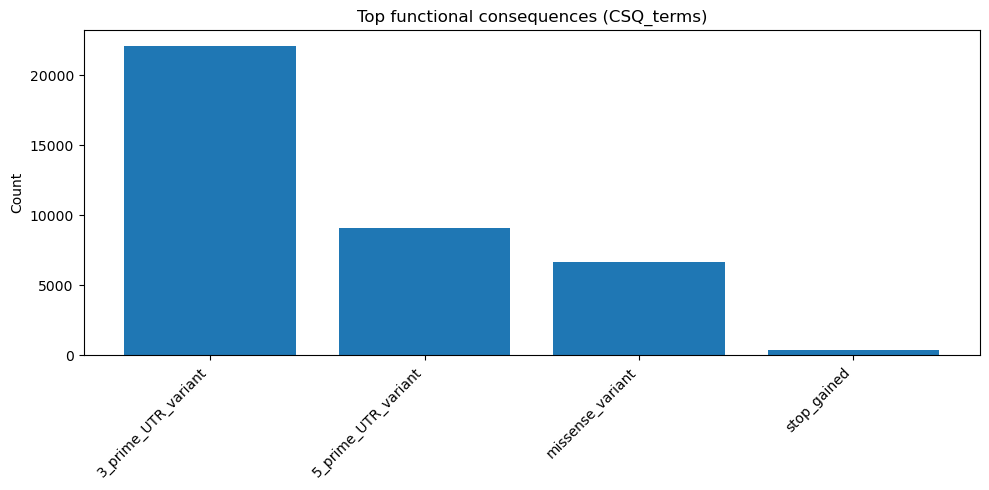

In [3]:
## Visualize distribution of functional variants
import os, glob, pandas as pd
import matplotlib.pyplot as plt

OUTDIR = "per_chrom_outputs_new"

# Load all annotated tables
paths = sorted(glob.glob(os.path.join(OUTDIR, "chr*.annotated.csv")))
dfs = [pd.read_csv(p, dtype=str) for p in paths]
annot = pd.concat(dfs, ignore_index=True) if dfs else pd.DataFrame()

# Guard if nothing loaded
if annot.empty or "CSQ_terms_str" not in annot.columns:
    print("No annotated data or CSQ_terms_str column not found.")
else:
    # explode comma-separated CSQ_terms into rows
    csq = (
        annot.assign(CSQ_terms_str=annot["CSQ_terms_str"].fillna(""))
             .assign(term=lambda d: d["CSQ_terms_str"].str.split(","))
             .explode("term")
    )
    csq["term"] = csq["term"].fillna("").str.strip()
    csq = csq[csq["term"] != ""]

    # counts overall
    csq_counts = csq["term"].value_counts().rename_axis("term").reset_index(name="count")
    display(csq_counts.head(20))

    # optional: counts by chromosome
    if "CHROM" in csq.columns:
        csq_by_chr = (
            csq.groupby(["CHROM","term"]).size().reset_index(name="count")
               .sort_values(["CHROM","count"], ascending=[True, False])
        )
        display(csq_by_chr.head(50))

    # quick bar chart of top 15 terms
    topN = 15
    top = csq_counts.head(topN)
    plt.figure(figsize=(10,5))
    plt.bar(top["term"], top["count"])
    plt.xticks(rotation=45, ha="right")
    plt.title("Top functional consequences (CSQ_terms)")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

    # save summaries
    csq_counts.to_csv(os.path.join(OUTDIR, "functional_counts_overall.csv"), index=False)
    if "CHROM" in csq.columns:
        csq_by_chr.to_csv(os.path.join(OUTDIR, "functional_counts_by_chrom.csv"), index=False)


,CLNSIG_label,count
0,Unknown code: nan,1612694
1,Benign,24053
2,Likely benign,801
3,Uncertain significance,253
4,other,157
5,Benign/Likely benign,110
6,not provided,71
7,Risk factor,56
8,Drug response,49
9,Association,31


,CLNSIG_bucket,count
0,Other,1613094
1,Benign (any),24964
2,Uncertain,255
3,Pathogenic (any),38
4,Conflicting,22


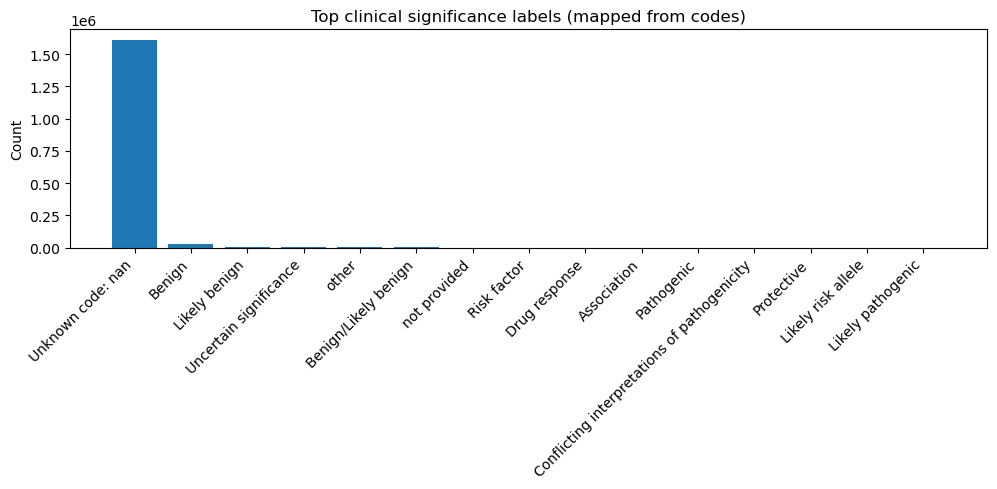

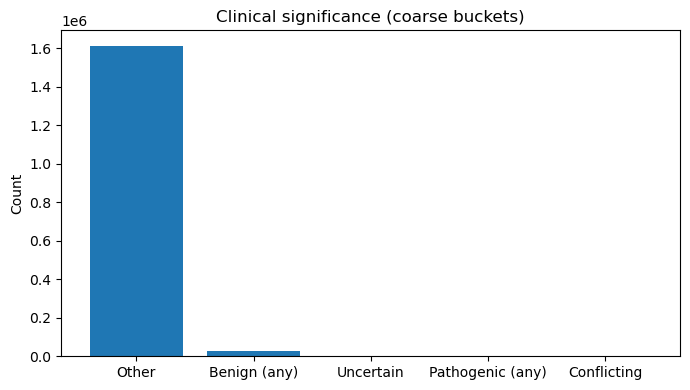

In [4]:
# Visualize Distribution of Clinically Annotated Variants
import os, glob, re, pandas as pd
import matplotlib.pyplot as plt

OUTDIR = "per_chrom_outputs_new"

# Load all annotated per-chrom files
paths = sorted(glob.glob(os.path.join(OUTDIR, "chr*.annotated.csv")))
dfs = [pd.read_csv(p, dtype=str) for p in paths]
annot = pd.concat(dfs, ignore_index=True) if dfs else pd.DataFrame()

if annot.empty or "CLNSIG" not in annot.columns:
    print("No annotated data or CLNSIG column not found.")
else:
    # Mapping from numeric code -> label (from your VCF header)
    CLNSIG_MAP = {
        "0":  "Uncertain significance",
        "1":  "not provided",
        "2":  "Benign",
        "3":  "Likely benign",
        "4":  "Likely pathogenic",
        "5":  "Pathogenic",
        "6":  "Drug response",
        "8":  "Confers sensitivity",
        "9":  "Risk factor",
        "10": "Association",
        "11": "Protective",
        "12": "Conflicting interpretations of pathogenicity",
        "13": "Affects",
        "14": "Association not found",
        "15": "Benign/Likely benign",
        "16": "Pathogenic/Likely pathogenic",
        "17": "Conflicting data from submitters",
        "18": "Pathogenic, low penetrance",
        "19": "Likely pathogenic, low penetrance",
        "20": "Established risk allele",
        "21": "Likely risk allele",
        "22": "Uncertain risk allele",
        "255":"other",
        ".":  None,   # treat '.' as missing
        "":   None,
    }

    # Split CLNSIG on common delimiters (/,; or |), map each code to a label, explode to 1-per-row
    splitter = re.compile(r"[\/;\|,]+")
    cln = (
        annot.assign(CLNSIG=annot["CLNSIG"].fillna(""))
             .assign(code_list=lambda d: d["CLNSIG"].apply(lambda s: [t.strip() for t in splitter.split(s) if t.strip()]))
             .explode("code_list")
    )

    # Map numeric code to label; keep unknowns as 'Unknown code: X'
    def code_to_label(code):
        if code in CLNSIG_MAP:
            return CLNSIG_MAP[code]
        return f"Unknown code: {code}" if code not in (None, "") else None

    cln["CLNSIG_label"] = cln["code_list"].map(code_to_label)
    cln = cln[cln["CLNSIG_label"].notna()]

    # Optional: add coarse buckets for quick rollups
    def bucket(label: str) -> str:
        if label in ("Pathogenic","Likely pathogenic","Pathogenic/Likely pathogenic",
                     "Pathogenic, low penetrance","Likely pathogenic, low penetrance"):
            return "Pathogenic (any)"
        if label in ("Benign","Likely benign","Benign/Likely benign"):
            return "Benign (any)"
        if label in ("Uncertain significance","Uncertain risk allele"):
            return "Uncertain"
        if label in ("Conflicting interpretations of pathogenicity","Conflicting data from submitters"):
            return "Conflicting"
        return "Other"

    cln["CLNSIG_bucket"] = cln["CLNSIG_label"].map(bucket)

    # Counts: detailed and buckets
    sig_counts = cln["CLNSIG_label"].value_counts().rename_axis("CLNSIG_label").reset_index(name="count")
    bucket_counts = cln["CLNSIG_bucket"].value_counts().rename_axis("CLNSIG_bucket").reset_index(name="count")

    display(sig_counts.head(30))
    display(bucket_counts)

    # Save tables
    sig_counts.to_csv(os.path.join(OUTDIR, "clinical_counts_labels_overall.csv"), index=False)
    bucket_counts.to_csv(os.path.join(OUTDIR, "clinical_counts_buckets_overall.csv"), index=False)

    # Bar chart of top 15 detailed labels
    topN = 15
    top = sig_counts.head(topN)
    plt.figure(figsize=(10,5))
    plt.bar(top["CLNSIG_label"], top["count"])
    plt.xticks(rotation=45, ha="right")
    plt.title("Top clinical significance labels (mapped from codes)")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

    # Bar chart of coarse buckets
    plt.figure(figsize=(7,4))
    plt.bar(bucket_counts["CLNSIG_bucket"], bucket_counts["count"])
    plt.xticks(rotation=0)
    plt.title("Clinical significance (coarse buckets)")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

    # (Optional) Per-chromosome breakdowns
    if "CHROM" in cln.columns:
        per_chr_labels = (
            cln.groupby(["CHROM","CLNSIG_label"]).size().reset_index(name="count")
               .sort_values(["CHROM","count"], ascending=[True, False])
        )
        per_chr_buckets = (
            cln.groupby(["CHROM","CLNSIG_bucket"]).size().reset_index(name="count")
               .sort_values(["CHROM","count"], ascending=[True, False])
        )
        per_chr_labels.to_csv(os.path.join(OUTDIR, "clinical_counts_labels_by_chrom.csv"), index=False)
        per_chr_buckets.to_csv(os.path.join(OUTDIR, "clinical_counts_buckets_by_chrom.csv"), index=False)


In [3]:
# =============================================================
# Association analysis on clinically annotated SNPs
# - Loads annotated files from per_chrom_outputs_new
# - Maps CLNSIG numeric codes → labels
# - Filters out missing / unknown codes
# - Runs per-variant association per trait:
#       * Logistic regression for binary traits (e.g. asthma)
#       * Linear regression for quantitative traits
# - FIXES:
#     * Sample detection = only phenotype IDs (no extra columns)
#     * Trait typing = numeric vs binary decided robustly
# - UPDATED:
#     * Treat IgE_Value and BMI as TRAITS (i.e. run association against them)
#     * IgE_Value is analyzed on log10 scale (standard IgE practice)
#     * Do NOT add them as covariates
#     * ALSO run trait associations separately:
#           - ONLY in asthma cases
#           - ONLY in non-asthma subjects
#     * NEW: save R^2 (linear) or pseudo-R^2 (logistic) per SNP
# =============================================================
import os, glob, re, warnings
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.stats.multitest import multipletests
from statsmodels.tools.sm_exceptions import ConvergenceWarning, PerfectSeparationWarning

# ---------- Silence noisy warnings ----------
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=PerfectSeparationWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
np.seterr(divide="ignore", invalid="ignore", over="ignore")

# ========= User inputs =========
PHENO_PATH   = "ImmPort_URECA_Cross_Black.csv"
PHENO_ID_COL = "id"

# Traits to analyze (asthma is binary; others are quantitative)
TRAITS       = ["asthma", "max_pets", "num_smokers", "IgE_Value", "BMI"]

OUTDIR_ANN   = "per_chrom_outputs_new"
OUT_PREFIX   = "assoc_clinical"
# ==============================

# ---------- Helpers ----------
def norm(s: str) -> str:
    return re.sub(r"\W+", "_", str(s).strip().lower())

def resolve_trait_columns(pheno_df: pd.DataFrame, wanted_traits: list[str]) -> dict:
    """
    Map user-friendly trait names to actual column names in the phenotype file,
    allowing for differences in case/spacing/underscore.
    """
    colmap = {norm(c): c for c in pheno_df.columns}
    resolved = {}
    for t in wanted_traits:
        key = norm(t)
        if key in colmap:
            resolved[t] = colmap[key]
        else:
            # fuzzy: asthma -> asthma_status, IgE_Value -> ige_value, etc.
            cands = [c for k, c in colmap.items() if key == k or key in k]
            if len(cands) == 1:
                resolved[t] = cands[0]
            else:
                raise KeyError(
                    f"Could not find trait column for '{t}'. "
                    f"Available (normalized) include: {list(sorted(colmap.keys())[:20])} ..."
                )
    return resolved

def decide_trait(y_raw: pd.Series):
    """
    Decide if a trait is binary or numeric.
    - If coercing to numeric gives >2 unique values → numeric
    - Else try typical binary strings
    - Else if values are {0,1} → binary
    - Else → numeric
    """
    y_num = pd.to_numeric(y_raw, errors="coerce")
    nuniq = y_num.dropna().nunique()

    sl = y_raw.astype(str).str.strip().str.lower()
    bin_map = {
        "1": 1, "0": 0,
        "yes": 1, "no": 0,
        "true": 1, "false": 0,
        "y": 1, "n": 0,
        "asthma": 1, "no asthma": 0,
        "present": 1, "absent": 0,
        "case": 1, "control": 0
    }
    y_bin = sl.map(bin_map).astype(float)
    coverage = y_bin.notna().mean()

    if nuniq > 2:
        # clearly quantitative
        return y_num.astype(float), False
    if coverage >= 0.9:
        # mapped well to 0/1
        return y_bin, True
    if set(pd.unique(y_num.dropna())).issubset({0,1}):
        # already numeric 0/1
        return y_num.astype(float), True
    return y_num.astype(float), False

def gt_to_dosage(field: str) -> float:
    """
    Convert VCF-like GT field to dosage 0/1/2.
    """
    if not isinstance(field, str) or field == "" or field == ".":
        return np.nan
    gt = field.split(":", 1)[0]
    if gt in {"./.", ".|.", "."}:
        return np.nan
    if "/" in gt:
        a1, a2 = gt.split("/")
    elif "|" in gt:
        a1, a2 = gt.split("|")
    else:
        return np.nan
    if a1 not in {"0","1"} or a2 not in {"0","1"}:
        return np.nan
    return float((a1 == "1") + (a2 == "1"))

def maf_from_dosage(dosages: np.ndarray) -> float | None:
    x = dosages[~np.isnan(dosages)]
    n = x.size
    if n == 0:
        return None
    af = x.sum() / (2.0 * n)
    return float(min(af, 1 - af))

# Map CLNSIG numeric codes → labels
CLNSIG_MAP = {
    "0":  "Uncertain significance",
    "1":  "not provided",
    "2":  "Benign",
    "3":  "Likely benign",
    "4":  "Likely pathogenic",
    "5":  "Pathogenic",
    "6":  "Drug response",
    "8":  "Confers sensitivity",
    "9":  "Risk factor",
    "10": "Association",
    "11": "Protective",
    "12": "Conflicting interpretations of pathogenicity",
    "13": "Affects",
    "14": "Association not found",
    "15": "Benign/Likely benign",
    "16": "Pathogenic/Likely pathogenic",
    "17": "Conflicting data from submitters",
    "18": "Pathogenic, low penetrance",
    "19": "Likely pathogenic, low penetrance",
    "20": "Established risk allele",
    "21": "Likely risk allele",
    "22": "Uncertain risk allele",
    "255":"other",
    ".":  None,
    "":   None,
}
CLNSIG_SPLIT = re.compile(r"[\/;\|,]+")

def clnsig_codes_to_labels(clnsig_val: str) -> list[str]:
    if not isinstance(clnsig_val, str):
        return []
    codes = [t.strip() for t in CLNSIG_SPLIT.split(clnsig_val) if t.strip() != ""]
    labels = []
    for code in codes:
        if code in CLNSIG_MAP:
            lab = CLNSIG_MAP[code]
            if lab:
                labels.append(lab)
    return labels

# ----------------- Load phenotype + annotated variants -----------------
pheno = pd.read_csv(PHENO_PATH)

# Resolve trait columns (handles things like "asthma " vs "asthma")
trait_col_map = resolve_trait_columns(pheno, TRAITS)
print("[info] Resolved trait columns:", trait_col_map)

# Normalize phenotype IDs to string index
pheno_ids = pheno[PHENO_ID_COL].astype(str)
pheno = pheno.set_index(pheno_ids).copy()
pheno.index.name = "sample_id"

# Load annotated tables
ann_paths = sorted(glob.glob(os.path.join(OUTDIR_ANN, "chr*.annotated.csv")))
if not ann_paths:
    raise FileNotFoundError(f"No annotated files found in {OUTDIR_ANN}. Expected chr*.annotated.csv")

annot = pd.concat(
    [pd.read_csv(p, dtype=str, low_memory=False) for p in ann_paths],
    ignore_index=True
)

# Clinical filter (keep variants with at least one CLNSIG label)
annot["CLNSIG"] = annot["CLNSIG"].fillna("")
annot["CLNSIG_labels_list"] = annot["CLNSIG"].apply(clnsig_codes_to_labels)
annot["CLNSIG_labels_str"]  = annot["CLNSIG_labels_list"].apply(lambda xs: "|".join(xs))
clin_mask = annot["CLNSIG_labels_list"].apply(lambda xs: len(xs) > 0)
annot_clin = annot[clin_mask].copy()

print(f"[info] Variants total: {annot.shape[0]:,}  |  with valid clinical labels: {annot_clin.shape[0]:,}")

# Build variant_id
annot_clin["variant_id"] = (
    annot_clin["#CHROM"].astype(str) + ":" +
    annot_clin["POS"].astype(str)    + ":" +
    annot_clin["REF"].astype(str)    + ":" +
    annot_clin["ALT"].astype(str)
)

# Sample columns are those that match phenotype IDs
sample_cols_clean = [c for c in annot_clin.columns if c in pheno.index]
if not sample_cols_clean:
    raise RuntimeError("No genotype sample columns matched phenotype IDs.")
overlap = sample_cols_clean
print(f"[info] Overlapping samples (all subjects): {len(overlap)}")

# ---- Build asthma case / non-case subsets for stratified analyses ----
asthma_col = trait_col_map["asthma"]
asthma_raw = pheno.loc[overlap, asthma_col]
asthma_y, asthma_binary = decide_trait(asthma_raw)
if not asthma_binary:
    print("[warn] Asthma column did not resolve cleanly to binary; stratified analyses may be unreliable.")

mask_asthma     = (asthma_y == 1)
mask_nonasthma  = (asthma_y == 0)

overlap_asthma = [sid for sid, m in zip(overlap, mask_asthma.values) if pd.notna(m) and m]
overlap_nonasthma = [sid for sid, m in zip(overlap, mask_nonasthma.values) if pd.notna(m) and m]

print(f"[info] Asthma-only samples: {len(overlap_asthma)}")
print(f"[info] Non-asthma-only samples: {len(overlap_nonasthma)}")

# ----------------- Association core -----------------
def run_assoc_for_trait(trait_name: str, sample_ids, label: str = "") -> pd.DataFrame:
    """
    Run association for a given trait in the specified sample subset.

    trait_name : one of TRAITS
    sample_ids : list of sample IDs to include
    label      : string used only for logging (e.g. 'asthmaOnly')
    """
    if len(sample_ids) < 10:
        print(f"[trait {trait_name} | {label}] Too few samples ({len(sample_ids)}) – skipping.")
        return pd.DataFrame(columns=[
            "variant_id","CHROM","POS","REF","ALT","MAF","N",
            "beta","se","pval","r2","qval_fdr","CLNSIG_labels"
        ])

    ph_col = trait_col_map[trait_name]
    y_raw = pheno.loc[sample_ids, ph_col]

    # SPECIAL CASE: IgE_Value is analyzed on log10 scale
    if trait_name == "IgE_Value":
        y_raw = np.log10(pd.to_numeric(y_raw, errors="coerce"))
        print(f"[trait {trait_name} | {label}] Using log10(IgE_Value) as the quantitative trait.")

    # Decide binary vs numeric for this trait within this subset
    y, binary = decide_trait(y_raw)
    print(f"[trait {trait_name} | {label}] Interpreted as {'BINARY' if binary else 'NUMERIC'}; "
          f"non-missing={y.notna().sum()}")

    results = []
    for _, row in annot_clin.iterrows():
        # Dosage for the selected samples
        g = np.array([gt_to_dosage(row[s]) for s in sample_ids], dtype=float)

        # Build df with y and genotype dosage
        df = pd.DataFrame({"y": y.values, "g": g}, index=sample_ids).dropna(subset=["y", "g"])
        if df.shape[0] < 10:
            continue

        # Design matrix: intercept + genotype (additive model)
        X = sm.add_constant(df["g"].values, has_constant="add")

        try:
            if binary:
                fit = sm.Logit(df["y"].values, X).fit(disp=False)
                r2  = float(fit.prsquared)  # McFadden pseudo-R^2
            else:
                fit = sm.OLS(df["y"].values, X).fit()
                r2  = float(fit.rsquared)   # standard R^2
            beta = float(fit.params[1])
            se   = float(fit.bse[1])
            pval = float(fit.pvalues[1])
        except Exception:
            # If a rare variant causes perfect separation or other issues, skip it
            continue

        maf = maf_from_dosage(df["g"].values)
        results.append({
            "variant_id": row["variant_id"],
            "CHROM": row["#CHROM"],
            "POS": int(row["POS"]),
            "REF": row["REF"],
            "ALT": row["ALT"],
            "MAF": maf,
            "N": int(df.shape[0]),
            "beta": beta,
            "se": se,
            "pval": pval,
            "r2": r2,
            "CLNSIG_labels": row["CLNSIG_labels_str"]
        })

    if not results:
        print(f"[trait {trait_name} | {label}] No analyzable variants produced results.")
        return pd.DataFrame(columns=[
            "variant_id","CHROM","POS","REF","ALT","MAF","N",
            "beta","se","pval","r2","qval_fdr","CLNSIG_labels"
        ])

    out = pd.DataFrame(results)
    out["qval_fdr"] = multipletests(out["pval"].values, method="fdr_bh")[1]
    out = out.sort_values("pval", ascending=True).reset_index(drop=True)
    return out

# ----------------- Run and save -----------------
all_outputs = {}

# 1) Full-cohort analyses (same as before)
for trait in TRAITS:
    res = run_assoc_for_trait(trait, overlap, label="all")
    out_path = f"{OUT_PREFIX}_{trait}.csv"
    res.to_csv(out_path, index=False)
    all_outputs[f"{trait}_all"] = out_path
    print(f"[save] {trait} (all) -> {out_path} (variants tested: {res.shape[0]})")

# 2) Stratified analyses: asthma-only and non-asthma-only
#    We only run these for quantitative traits (no point running 'asthma' within asthma-only).
STRAT_TRAITS = [t for t in TRAITS if t != "asthma"]

for trait in STRAT_TRAITS:
    # asthma-only
    res_a = run_assoc_for_trait(trait, overlap_asthma, label="asthmaOnly")
    out_path_a = f"{OUT_PREFIX}_asthmaOnly_{trait}.csv"
    res_a.to_csv(out_path_a, index=False)
    all_outputs[f"{trait}_asthmaOnly"] = out_path_a
    print(f"[save] {trait} (asthmaOnly) -> {out_path_a} (variants tested: {res_a.shape[0]})")

    # non-asthma-only
    res_n = run_assoc_for_trait(trait, overlap_nonasthma, label="nonAsthmaOnly")
    out_path_n = f"{OUT_PREFIX}_nonAsthmaOnly_{trait}.csv"
    res_n.to_csv(out_path_n, index=False)
    all_outputs[f"{trait}_nonAsthmaOnly"] = out_path_n
    print(f"[save] {trait} (nonAsthmaOnly) -> {out_path_n} (variants tested: {res_n.shape[0]})")

print("\nDone. Top rows from each output:")
for key, path in all_outputs.items():
    try:
        print(f"\n### {key} ###")
        print(pd.read_csv(path, nrows=5).to_string(index=False))
    except Exception:
        pass


[info] Resolved trait columns: {'asthma': 'asthma ', 'max_pets': 'max_pets', 'num_smokers': 'num_smokers', 'IgE_Value': 'IgE_Value', 'BMI': 'BMI'}
[info] Variants total: 1,629,382  |  with valid clinical labels: 16,688
[info] Overlapping samples (all subjects): 119
[info] Asthma-only samples: 110
[info] Non-asthma-only samples: 9
[trait asthma | all] Interpreted as BINARY; non-missing=119
[save] asthma (all) -> assoc_clinical_asthma.csv (variants tested: 16482)
[trait max_pets | all] Interpreted as NUMERIC; non-missing=119
[save] max_pets (all) -> assoc_clinical_max_pets.csv (variants tested: 16687)
[trait num_smokers | all] Interpreted as NUMERIC; non-missing=119
[save] num_smokers (all) -> assoc_clinical_num_smokers.csv (variants tested: 16687)
[trait IgE_Value | all] Using log10(IgE_Value) as the quantitative trait.
[trait IgE_Value | all] Interpreted as NUMERIC; non-missing=119
[save] IgE_Value (all) -> assoc_clinical_IgE_Value.csv (variants tested: 16687)
[trait BMI | all] Interpr

In [4]:
# ===== Plotting + Significant-Hits Table (auto-detects file prefix) =====
import os, re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import chi2

# ---- CONFIG ----
PHENO_PATH   = "ImmPort_URECA_Cross_Black.csv"
PHENO_ID_COL = "id"

# BMI + IgE as traits
TRAITS       = ["asthma", "max_pets", "num_smokers", "IgE_Value", "BMI"]

FDR_ALPHA    = 0.05
P_MIN        = 1e-300

# Preferred prefixes to search (first that exists per-trait will be used)
PREFERRED_PREFIXES = ["assoc_clinical", "assoc_chr5", "assoc_chr5_fast"]

# Significant-table outputs
SIG_TABLE_ALL          = "significant_hits_all_FDR_lt_0p05.csv"
SIG_TABLE_ASTHMA_ONLY  = "significant_hits_asthmaOnly_FDR_lt_0p05.csv"
SIG_TABLE_NONASTH_ONLY = "significant_hits_nonAsthmaOnly_FDR_lt_0p05.csv"

ANNOTATED_DIR = "per_chrom_outputs_new"

# ======================================================================
# helpers
# ======================================================================
def _norm(s: str) -> str:
    return re.sub(r"\W+", "_", str(s).strip().lower())

def _resolve_trait_cols(pheno_df: pd.DataFrame, names: list[str]) -> dict:
    colmap = { _norm(c): c for c in pheno_df.columns }
    resolved = {}
    for t in names:
        key = _norm(t)
        if key not in colmap:
            raise KeyError(f"Trait '{t}' not found (case/space-insensitive).")
        resolved[t] = colmap[key]
    return resolved

def _ensure_cols(df: pd.DataFrame) -> pd.DataFrame:
    if df.empty:
        return df
    df = df.copy()
    df["mlog10p"] = -np.log10(np.clip(df["pval"].values.astype(float), P_MIN, 1.0))
    df["hit"] = (df["qval_fdr"].values.astype(float) <= FDR_ALPHA)
    df["POS"] = pd.to_numeric(df["POS"], errors="coerce")
    df["CHROM"] = df["CHROM"].astype(str)
    return df

def _savefig(path: str):
    plt.tight_layout()
    plt.savefig(path, dpi=220, bbox_inches="tight")
    plt.close()
    print(f"[fig] saved -> {path}")

def decide_trait(y_raw: pd.Series):
    y_num = pd.to_numeric(y_raw, errors="coerce")
    nuniq = y_num.dropna().nunique()
    sl = y_raw.astype(str).str.strip().str.lower()
    bin_map = {
        "1": 1, "0": 0,
        "yes": 1, "no": 0,
        "true": 1, "false": 0,
        "y": 1, "n": 0,
        "asthma": 1, "no asthma": 0,
        "present": 1, "absent": 0,
        "case": 1, "control": 0
    }
    y_bin = sl.map(bin_map).astype(float)
    coverage = y_bin.notna().mean()
    if nuniq > 2:
        return y_num.astype(float), False
    if coverage >= 0.9:
        return y_bin, True
    if set(pd.unique(y_num.dropna())).issubset({0,1}):
        return y_num.astype(float), True
    return y_num.astype(float), False

def plot_trait_quicklook(trait_name, series, out_prefix, subset_label="all"):
    y, is_binary = decide_trait(series)
    label_suffix = "" if subset_label == "all" else f"_{subset_label}"
    fig_path = f"{out_prefix}_{trait_name}{label_suffix}_trait_quicklook.png"
    plt.figure(figsize=(6,4))
    if is_binary:
        vals = y.dropna().astype(int)
        plt.bar(["0","1"], [(vals==0).sum(), (vals==1).sum()])
        plt.ylabel("Count"); plt.title(f"{trait_name} (binary) counts – {subset_label}")
    else:
        yn = y.dropna()
        plt.hist(yn.values, bins=30)
        plt.xlabel(trait_name); plt.ylabel("Frequency"); plt.title(f"{trait_name} distribution – {subset_label}")
    _savefig(fig_path)

# ======================================================================
# MANHATTAN
# ======================================================================
def manhattan(df, trait_name, out_prefix, subset_label="all", fdr_alpha=FDR_ALPHA):
    df = _ensure_cols(df)
    if df.empty or df["POS"].isna().all():
        print(f"[{trait_name} | {subset_label}] No results to plot (Manhattan).")
        return

    def chr_key(c):
        c = str(c).replace("chr","")
        try:
            return (0, int(c))
        except:
            order = {"X": 23, "Y": 24, "MT": 25, "M":25}
            return (1, order.get(c, 99))

    chroms = sorted(df["CHROM"].unique(), key=chr_key)

    offsets = {}
    current = 0
    tick_positions = []
    tick_labels = []
    for c in chroms:
        subset = df.loc[df["CHROM"]==c, "POS"].dropna()
        if subset.empty:
            offsets[c] = current
            continue
        minpos, maxpos = subset.min(), subset.max()
        offsets[c] = current
        tick_positions.append(current + (minpos + maxpos)/2.0)
        tick_labels.append(str(c))
        current += maxpos + 3e5

    df["cum_pos"] = df.apply(lambda r: r["POS"] + offsets.get(str(r["CHROM"]), 0), axis=1)

    m = max(len(df), 1)
    bonf_p = 0.05 / m
    bonf_y = -np.log10(max(bonf_p, P_MIN))

    hits = df["hit"].values
    has_fdr_hits = hits.any()
    if has_fdr_hits:
        p_fdr_cut = float(df.loc[hits, "pval"].max())
        fdr_y = -np.log10(max(p_fdr_cut, P_MIN))
    else:
        fdr_y = None

    chrom_colors = [
        "#a23b3b", "#5f5f5f", "#2f6f3e", "#4f3b3b", "#6f7f7f",
        "#ac8740", "#7ad0f5", "#111111", "#a65065", "#b06840",
        "#5a4fd0", "#c1b741"
    ]

    label_suffix = "" if subset_label == "all" else f"_{subset_label}"
    fig_path = f"{out_prefix}_{trait_name}{label_suffix}_manhattan.png"
    plt.figure(figsize=(11.5,4.2))

    for i, c in enumerate(chroms):
        mask = (df["CHROM"] == c)
        col = chrom_colors[i % len(chrom_colors)]
        plt.scatter(
            df.loc[mask, "cum_pos"],
            df.loc[mask, "mlog10p"],
            s=10,
            alpha=0.8,
            c=col,
            edgecolor="none",
            zorder=1
        )

    plt.axhline(bonf_y, linestyle="--", linewidth=1.1, color="black",
                label=f"Bonferroni 0.05 (p<{bonf_p:.1e})")
    if fdr_y is not None:
        plt.axhline(fdr_y, linestyle=":", linewidth=1.2, color="purple",
                    label=f"FDR<{fdr_alpha}")

    # --- jittered labels for FDR-significant hits ---
    if has_fdr_hits:
        sig_df = df.loc[hits].sort_values("pval")
        top_hits = sig_df.head(15)  # up to 15 labels
        # Sort by chromosome position so neighboring peaks are offset nicely
        top_hits = top_hits.sort_values(["CHROM", "cum_pos"]).reset_index(drop=True)

        for i, (_, r) in enumerate(top_hits.iterrows()):
            label = (
                r.get("rsID")
                or r.get("rsid")
                or r.get("ID")
                or r.get("SYMBOL")
                or r.get("gene")
                or r.get("Gene.refGene")
                or r["variant_id"]
            )
            # deterministic jitter: alternate x and stack vertically
            x_jitter = (i % 3 - 1) * 5e5      # -0.5Mb, 0, +0.5Mb
            y_jitter = 0.35 + (i // 3) * 0.4  # stack rows
            plt.text(
                r["cum_pos"] + x_jitter,
                r["mlog10p"] + y_jitter,
                str(label),
                fontsize=7,
                rotation=20,
                ha="left",
                va="bottom",
                color="black",
                zorder=2
            )

    plt.xticks(tick_positions, tick_labels, fontsize=8)
    plt.xlabel("Chromosomes")
    plt.ylabel(r"$-\log_{10}(P)$")
    title_subset = "all subjects" if subset_label == "all" else subset_label
    plt.title(f"Manhattan – {trait_name} ({title_subset})")
    plt.legend(frameon=False, fontsize=7, loc="upper right")
    _savefig(fig_path)

# ======================================================================
# VOLCANO — standard GWAS-style
# ======================================================================
def volcano(df, trait_name, out_prefix, subset_label="all"):
    df = _ensure_cols(df)
    if df.empty:
        print(f"[{trait_name} | {subset_label}] No results to plot (volcano).")
        return

    x = df["beta"].values.astype(float)
    y = df["mlog10p"].values

    # Significance by FDR
    sig = df["qval_fdr"].astype(float) <= FDR_ALPHA
    ns  = ~sig

    # Bonferroni line
    m = max(len(df), 1)
    bonf_p = 0.05 / m
    bonf_y = -np.log10(max(bonf_p, P_MIN))

    # (optional) FDR cutoff line at the max p among FDR-significant hits
    if sig.any():
        p_fdr_cut = float(df.loc[sig, "pval"].max())
        fdr_y = -np.log10(max(p_fdr_cut, P_MIN))
    else:
        fdr_y = None

    label_suffix = "" if subset_label == "all" else f"_{subset_label}"
    fig_path = f"{out_prefix}_{trait_name}{label_suffix}_volcano.png"
    plt.figure(figsize=(6,5))

    # NS grey
    plt.scatter(x[ns], y[ns], s=12, alpha=0.35, c="lightgrey", edgecolor="none", label="Not sig", zorder=1)

    # FDR-significant points in color
    plt.scatter(x[sig], y[sig], s=18, alpha=0.9, c="#d95f02", edgecolor="none", label=f"FDR<{FDR_ALPHA}", zorder=2)

    # Horizontal lines
    plt.axhline(bonf_y, linestyle="--", linewidth=1, color="black",
                label=f"Bonf 0.05 (p<{bonf_p:.1e})")
    if fdr_y is not None:
        plt.axhline(fdr_y, linestyle=":", linewidth=1, color="purple",
                    label="FDR cutoff")

    # Label top hits (by p-value) with jitter to avoid overlap
    if sig.any():
        top = df.loc[sig].sort_values("pval").head(12)
    else:
        top = df.sort_values("pval").head(12)

    for i, (_, r) in enumerate(top.iterrows()):
        label = (
            r.get("rsID")
            or r.get("rsid")
            or r.get("ID")
            or r.get("SYMBOL")
            or r.get("gene")
            or r.get("Gene.refGene")
            or r["variant_id"]
        )
        x_jitter = (i % 3 - 1) * 0.2       # -0.2, 0, +0.2
        y_jitter = 0.2 + (i // 3) * 0.25   # stack rows upwards
        plt.text(
            r["beta"] + x_jitter,
            r["mlog10p"] + y_jitter,
            str(label),
            fontsize=7,
            color="red",
            ha="center",
            va="bottom",
            zorder=3
        )

    plt.xlabel("Effect size (β per ALT allele)")
    plt.ylabel(r"$-\log_{10}(\mathrm{Pvalue})$")
    title_subset = "all subjects" if subset_label == "all" else subset_label
    plt.title(f"Volcano – {trait_name} ({title_subset})")
    plt.legend(frameon=False, fontsize=7, loc="upper right")
    _savefig(fig_path)

# ======================================================================
# QQ + MAF
# ======================================================================
def qq_plot(df, trait_name, out_prefix, subset_label="all"):
    df = _ensure_cols(df)
    if df.empty:
        print(f"[{trait_name} | {subset_label}] No results to plot (QQ).")
        return
    p = np.clip(np.sort(df["pval"].values.astype(float)), P_MIN, 1.0)
    n = len(p)
    exp = (np.arange(1, n+1) - 0.5) / n
    o = -np.log10(p); e = -np.log10(exp)

    chisq = chi2.isf(p, df=1)
    lam_gc = np.median(chisq) / chi2.ppf(0.5, 1)

    label_suffix = "" if subset_label == "all" else f"_{subset_label}"
    fig_path = f"{out_prefix}_{trait_name}{label_suffix}_qq.png"
    plt.figure(figsize=(5,5))
    plt.scatter(e, o, s=6, alpha=0.6)
    lim = max(e.max(), o.max()) * 1.02
    plt.plot([0, lim], [0, lim], color="black", linewidth=1)
    plt.xlabel("Expected -log10(p)"); plt.ylabel("Observed -log10(p)")
    title_subset = "all subjects" if subset_label == "all" else subset_label
    plt.title(f"QQ plot – {trait_name} ({title_subset}) (λGC={lam_gc:.3f})")
    _savefig(fig_path)

def maf_vs_significance(df, trait_name, out_prefix, subset_label="all"):
    df = _ensure_cols(df)
    if df.empty:
        print(f"[{trait_name} | {subset_label}] No results to plot (MAF vs sig).")
        return
    maf = pd.to_numeric(df["MAF"], errors="coerce").values
    y   = df["mlog10p"].values
    hit = df["hit"].values
    label_suffix = "" if subset_label == "all" else f"_{subset_label}"
    fig_path = f"{out_prefix}_{trait_name}{label_suffix}_maf_vs_mlog10p.png"
    plt.figure(figsize=(6,5))
    plt.scatter(maf[~hit], y[~hit], s=8, alpha=0.6)
    if hit.any(): plt.scatter(maf[hit], y[hit], s=12, alpha=0.9)
    plt.xlabel("Minor Allele Frequency (MAF)"); plt.ylabel("-log10(p)")
    title_subset = "all subjects" if subset_label == "all" else subset_label
    plt.title(f"MAF vs significance – {trait_name} ({title_subset})")
    _savefig(fig_path)

# ======================================================================
# load phenotype & build annotation table (rsID/gene/functional)
# ======================================================================
pheno = pd.read_csv(PHENO_PATH)
trait_col_map = _resolve_trait_cols(pheno, TRAITS)
pheno = pheno.set_index(pheno[PHENO_ID_COL].astype(str)).copy()
pheno.index.name = "sample_id"

annot_merge = None
if ANNOTATED_DIR and os.path.isdir(ANNOTATED_DIR):
    ann_files = [os.path.join(ANNOTATED_DIR, f) for f in os.listdir(ANNOTATED_DIR) if f.endswith(".annotated.csv")]
    if ann_files:
        ann_list = []
        for f in sorted(ann_files):
            try:
                tmp = pd.read_csv(f, dtype=str, low_memory=False)
                ann_list.append(tmp)
            except Exception:
                pass
        if ann_list:
            annot_merge = pd.concat(ann_list, ignore_index=True)
            if "variant_id" not in annot_merge.columns and {"#CHROM","POS","REF","ALT"}.issubset(annot_merge.columns):
                annot_merge["variant_id"] = (
                    annot_merge["#CHROM"].astype(str) + ":" +
                    annot_merge["POS"].astype(str) + ":" +
                    annot_merge["REF"].astype(str) + ":" +
                    annot_merge["ALT"].astype(str)
                )
            keep_cols = ["variant_id", "#CHROM", "POS", "REF", "ALT"]
            rs_like = [c for c in annot_merge.columns if c.lower() in {"id","rsid","rs_id","rs"}]
            gene_like = [c for c in annot_merge.columns if c.lower() in {"gene","gene.refgene","symbol","gene_name"}]
            # NEW: functional annotation column (CSQ_terms_str) if present
            func_cols = [c for c in annot_merge.columns if c == "CSQ_terms_str"]
            keep_cols = keep_cols + rs_like + gene_like + func_cols
            annot_merge = annot_merge[keep_cols].drop_duplicates()

# overlap for trait quicklook (just to get a sample set; plots don't depend on genotypes)
overlap = list(pheno.index)
if ANNOTATED_DIR and os.path.isdir(ANNOTATED_DIR):
    any_file = None
    for name in sorted(os.listdir(ANNOTATED_DIR)):
        if name.endswith(".annotated.csv"):
            any_file = os.path.join(ANNOTATED_DIR, name)
            break
    if any_file:
        cols = list(pd.read_csv(any_file, nrows=0).columns)
        overlap = [c for c in cols if c in pheno.index]
print(f"[plot] Overlapping samples for quicklook: {len(overlap)}")

# ======================================================================
# main loop (all / asthma-only / non-asthma-only)
# ======================================================================
# contexts: (middle_tag_in_filename, subset_label, human_readable_suffix)
CONTEXTS = [
    ("",              "all",            ""),
    ("asthmaOnly_",   "asthmaOnly",     " (asthma only)"),
    ("nonAsthmaOnly_","nonAsthmaOnly",  " (non-asthma only)")
]

signif_frames = {c_label: [] for _, c_label, _ in CONTEXTS}

for trait in TRAITS:
    for mid_tag, subset_label, _suffix in CONTEXTS:
        # We do NOT expect stratified outputs for the asthma case/control trait itself
        if trait == "asthma" and subset_label != "all":
            continue

        assoc_path = None
        out_prefix_used = None

        for pref in PREFERRED_PREFIXES:
            if mid_tag == "":
                candidate = f"{pref}_{trait}.csv"
            else:
                candidate = f"{pref}_{mid_tag}{trait}.csv"
            if os.path.exists(candidate):
                assoc_path = candidate
                # prefix used in figure filenames
                out_prefix_used = pref if subset_label == "all" else f"{pref}_{subset_label}"
                break

        if assoc_path is None:
            print(f"[skip] No association file found for {trait} ({subset_label}).")
            continue

        res = pd.read_csv(assoc_path)

        # merge rsID/gene/functional info from annotation
        if annot_merge is not None:
            if "variant_id" in res.columns and "variant_id" in annot_merge.columns:
                res = res.merge(annot_merge, on="variant_id", how="left", suffixes=("", "_ann"))
            else:
                res = res.merge(
                    annot_merge,
                    left_on=["CHROM","POS","REF","ALT"],
                    right_on=["#CHROM","POS","REF","ALT"],
                    how="left",
                    suffixes=("", "_ann")
                )

        # trait distribution quicklook (uses all samples; subset doesn't change phenotype distribution much)
        ph_col = trait_col_map[trait]
        series = pheno.loc[overlap, ph_col]
        plot_trait_quicklook(trait, series, out_prefix=out_prefix_used, subset_label=subset_label)

        # GWAS-style plots for this subset
        manhattan(res, trait, out_prefix=out_prefix_used, subset_label=subset_label)
        qq_plot(res, trait, out_prefix=out_prefix_used, subset_label=subset_label)
        volcano(res, trait, out_prefix=out_prefix_used, subset_label=subset_label)
        maf_vs_significance(res, trait, out_prefix=out_prefix_used, subset_label=subset_label)

        # collect significant hits (FDR < 0.05)
        if "qval_fdr" not in res.columns:
            print(f"[warn] qval_fdr missing for {trait} ({subset_label}); skipping sig-table entry.")
            continue

        res_sig = res.loc[(res["qval_fdr"].astype(float) <= FDR_ALPHA)].copy()
        if not res_sig.empty:
            m = len(res)
            res_sig["bonf_sig"] = res_sig["pval"].astype(float) < (0.05 / max(m,1))
            res_sig["trait"] = trait
            res_sig["subset"] = subset_label

            # normalize rsID col name (if present)
            if "ID" in res_sig.columns:
                res_sig.rename(columns={"ID":"rsID"}, inplace=True)
            elif "rsid" in res_sig.columns:
                res_sig.rename(columns={"rsid":"rsID"}, inplace=True)
            elif "rs_id" in res_sig.columns:
                res_sig.rename(columns={"rs_id":"rsID"}, inplace=True)

            # gene annotations
            extra_anns = []
            for cand in ["gene","GENE","Gene.refGene","SYMBOL","gene_name"]:
                if cand in res_sig.columns:
                    extra_anns.append(cand)

            # functional annotation column
            func_cols = []
            if "CSQ_terms_str" in res_sig.columns:
                func_cols.append("CSQ_terms_str")

            base_cols = [
                "subset","trait","variant_id","CHROM","POS","REF","ALT",
                "MAF","N","beta","se","pval","qval_fdr","r2","bonf_sig",
                "rsID","CLNSIG_labels"
            ]
            base_cols = [c for c in base_cols if c in res_sig.columns]
            res_sig = res_sig[base_cols + func_cols + extra_anns]

            signif_frames[subset_label].append(res_sig)

# ---- Write separate significant tables ----
if signif_frames["all"]:
    sig_all = pd.concat(signif_frames["all"], ignore_index=True)
    sig_all = sig_all.sort_values(["trait","pval"]).reset_index(drop=True)
    sig_all.to_csv(SIG_TABLE_ALL, index=False)
    print(f"[table] Significant associations (all subjects, FDR<{FDR_ALPHA}) -> {SIG_TABLE_ALL}")
    try:
        print(sig_all.head(30).to_string(index=False))
    except Exception:
        print(sig_all.head(30))

if signif_frames["asthmaOnly"]:
    sig_asth = pd.concat(signif_frames["asthmaOnly"], ignore_index=True)
    sig_asth = sig_asth.sort_values(["trait","pval"]).reset_index(drop=True)
    sig_asth.to_csv(SIG_TABLE_ASTHMA_ONLY, index=False)
    print(f"[table] Significant associations (asthma-only, FDR<{FDR_ALPHA}) -> {SIG_TABLE_ASTHMA_ONLY}")
    try:
        print(sig_asth.head(30).to_string(index=False))
    except Exception:
        print(sig_asth.head(30))

if signif_frames["nonAsthmaOnly"]:
    sig_non = pd.concat(signif_frames["nonAsthmaOnly"], ignore_index=True)
    sig_non = sig_non.sort_values(["trait","pval"]).reset_index(drop=True)
    sig_non.to_csv(SIG_TABLE_NONASTH_ONLY, index=False)
    print(f"[table] Significant associations (non-asthma-only, FDR<{FDR_ALPHA}) -> {SIG_TABLE_NONASTH_ONLY}")
    try:
        print(sig_non.head(30).to_string(index=False))
    except Exception:
        print(sig_non.head(30))

if not (signif_frames["all"] or signif_frames["asthmaOnly"] or signif_frames["nonAsthmaOnly"]):
    print(f"[table] No variants met FDR<{FDR_ALPHA} in any subset.")


[plot] Overlapping samples for quicklook: 119
[fig] saved -> assoc_clinical_asthma_trait_quicklook.png
[fig] saved -> assoc_clinical_asthma_manhattan.png
[fig] saved -> assoc_clinical_asthma_qq.png
[fig] saved -> assoc_clinical_asthma_volcano.png
[fig] saved -> assoc_clinical_asthma_maf_vs_mlog10p.png
[fig] saved -> assoc_clinical_max_pets_trait_quicklook.png
[fig] saved -> assoc_clinical_max_pets_manhattan.png
[fig] saved -> assoc_clinical_max_pets_qq.png
[fig] saved -> assoc_clinical_max_pets_volcano.png
[fig] saved -> assoc_clinical_max_pets_maf_vs_mlog10p.png
[fig] saved -> assoc_clinical_asthmaOnly_max_pets_asthmaOnly_trait_quicklook.png
[fig] saved -> assoc_clinical_asthmaOnly_max_pets_asthmaOnly_manhattan.png
[fig] saved -> assoc_clinical_asthmaOnly_max_pets_asthmaOnly_qq.png
[fig] saved -> assoc_clinical_asthmaOnly_max_pets_asthmaOnly_volcano.png
[fig] saved -> assoc_clinical_asthmaOnly_max_pets_asthmaOnly_maf_vs_mlog10p.png
[fig] saved -> assoc_clinical_nonAsthmaOnly_max_pets_

In [ ]:
# =============================================================
# Association analysis (EXACT) on clinically annotated SNPs
# - Loads annotated files from per_chrom_outputs_new (same as before)
# - Maps CLNSIG numeric codes → labels (same)
# - Filters out missing / unknown codes (same)
# - NEW: For each trait:
#       * If binary → use as-is
#       * If numeric → binarize (default: median split, configurable)
# - Runs Fisher's exact tests for:
#       * Dominant model: carriers (1/2) vs non-carriers (0)
#       * Recessive model: hom-alt (2) vs others (0/1), if any 2s exist
# - BH-FDR correction within trait×model
# - Outputs per-trait CSVs with OR, pval, qval and model label
# =============================================================
import os, glob, re, warnings
import pandas as pd
import numpy as np
from scipy.stats import fisher_exact
from statsmodels.stats.multitest import multipletests
from statsmodels.tools.sm_exceptions import ConvergenceWarning, PerfectSeparationWarning

# ---------- Silence noisy warnings ----------
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=PerfectSeparationWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
np.seterr(divide="ignore", invalid="ignore", over="ignore")

# ========= User inputs =========
PHENO_PATH   = "ImmPort_URECA_Cross_Black.csv"
PHENO_ID_COL = "id"

# Include numeric (BMI, IgE) and binary/count traits here. We'll auto-detect numeric vs binary.
TRAITS       = ["asthma", "max_pets", "num_smokers", "BMI", "IgE_Value"]

# Optional: provide clinical thresholds to binarize specific numeric traits instead of median
# Format: {"TraitNameInTRAITS": cutoff_value}  → outcome = 1 if value >= cutoff else 0
CUSTOM_CUTOFFS = {
    # "BMI": 25.0,   # example: overweight+
    # "IgE": 100.0,  # example threshold (kU/L). Replace with your clinical cutoffs if desired.
}

# Where your pipeline wrote the annotated tables:
OUTDIR_ANN   = "per_chrom_outputs_new"
# Output prefix for association results:
OUT_PREFIX   = "assoc_exact_fisher"
# ==============================

# ---------- Helpers (yours, unchanged except tiny note on typing) ----------
def norm(s: str) -> str:
    return re.sub(r"\W+", "_", str(s).strip().lower())

def resolve_trait_columns(pheno_df: pd.DataFrame, wanted_traits: list[str]) -> dict:
    colmap = {norm(c): c for c in pheno_df.columns}
    resolved = {}
    for t in wanted_traits:
        key = norm(t)
        if key in colmap:
            resolved[t] = colmap[key]
        else:
            cands = [c for k, c in colmap.items() if key == k or key in k]
            if len(cands) == 1:
                resolved[t] = cands[0]
            else:
                raise KeyError(f"Could not find trait column for '{t}'. "
                               f"Some normalized columns: {list(sorted(colmap.keys()))[:15]} ...")
    return resolved

def coerce_binary_series(s: pd.Series) -> pd.Series:
    sl = s.astype(str).str.strip().str.lower()
    mapping = {
        "1": 1, "0": 0,
        "yes": 1, "no": 0,
        "true": 1, "false": 0,
        "y": 1, "n": 0,
        "asthma": 1, "no asthma": 0,
        "present": 1, "absent": 0,
        "case": 1, "control": 0
    }
    out = sl.map(mapping)
    if out.notna().sum() == 0:
        out = pd.to_numeric(s, errors="coerce")
    return out.astype(float)

def decide_trait(y_raw: pd.Series):
    """
    Decide if a trait is binary or numeric:
    - If numeric coercion has >2 unique non-NaN values => numeric
    - Else, try string→binary mapping; if coverage >= 90% => binary
    - Else, if numeric values are truly {0,1} => binary
    - Else => numeric
    """
    y_num = pd.to_numeric(y_raw, errors="coerce")
    nuniq = y_num.dropna().nunique()

    sl = y_raw.astype(str).str.strip().str.lower()
    bin_map = {
        "1": 1, "0": 0,
        "yes": 1, "no": 0,
        "true": 1, "false": 0,
        "y": 1, "n": 0,
        "asthma": 1, "no asthma": 0,
        "present": 1, "absent": 0,
        "case": 1, "control": 0
    }
    y_bin = sl.map(bin_map).astype(float)
    coverage = y_bin.notna().mean()

    if nuniq > 2:
        return y_num.astype(float), False
    if coverage >= 0.9:
        return y_bin, True
    if set(pd.unique(y_num.dropna())).issubset({0,1}):
        return y_num.astype(float), True
    return y_num.astype(float), False

def gt_to_dosage(field: str) -> float:
    # returns 0.0, 1.0, 2.0 or np.nan
    if not isinstance(field, str) or field == "" or field == ".":
        return np.nan
    gt = field.split(":", 1)[0]
    if gt in {"./.", ".|.", "."}:
        return np.nan
    if "/" in gt:
        a1, a2 = gt.split("/")
    elif "|" in gt:
        a1, a2 = gt.split("|")
    else:
        return np.nan
    if a1 not in {"0","1"} or a2 not in {"0","1"}:
        return np.nan
    return float((a1 == "1") + (a2 == "1"))

def maf_from_dosage(dosages: np.ndarray) -> float | None:
    x = dosages[~np.isnan(dosages)]
    n = x.size
    if n == 0: return None
    af = x.sum() / (2.0 * n)
    return float(min(af, 1 - af))

# Map CLNSIG numeric codes → labels (yours)
CLNSIG_MAP = {
    "0":  "Uncertain significance",
    "1":  "not provided",
    "2":  "Benign",
    "3":  "Likely benign",
    "4":  "Likely pathogenic",
    "5":  "Pathogenic",
    "6":  "Drug response",
    "8":  "Confers sensitivity",
    "9":  "Risk factor",
    "10": "Association",
    "11": "Protective",
    "12": "Conflicting interpretations of pathogenicity",
    "13": "Affects",
    "14": "Association not found",
    "15": "Benign/Likely benign",
    "16": "Pathogenic/Likely pathogenic",
    "17": "Conflicting data from submitters",
    "18": "Pathogenic, low penetrance",
    "19": "Likely pathogenic, low penetrance",
    "20": "Established risk allele",
    "21": "Likely risk allele",
    "22": "Uncertain risk allele",
    "255":"other",
    ".":  None,
    "":   None,
}
CLNSIG_SPLIT = re.compile(r"[\/;\|,]+")
def clnsig_codes_to_labels(clnsig_val: str) -> list[str]:
    if not isinstance(clnsig_val, str):
        return []
    codes = [t.strip() for t in CLNSIG_SPLIT.split(clnsig_val) if t.strip() != ""]
    labels = []
    for code in codes:
        if code in CLNSIG_MAP:
            lab = CLNSIG_MAP[code]
            if lab:
                labels.append(lab)
    return labels

# ----------------- Load phenotype + annotated variants -----------------
pheno = pd.read_csv(PHENO_PATH)

# Resolve trait columns (robust to spacing/case)
trait_col_map = resolve_trait_columns(pheno, TRAITS)
print("[info] Resolved trait columns:", trait_col_map)

# Normalize phenotype IDs to string index
pheno_ids = pheno[PHENO_ID_COL].astype(str)
pheno = pheno.set_index(pheno_ids).copy()
pheno.index.name = "sample_id"

# Load annotated tables
ann_paths = sorted(glob.glob(os.path.join(OUTDIR_ANN, "chr*.annotated.csv")))
if not ann_paths:
    raise FileNotFoundError(f"No annotated files found in {OUTDIR_ANN}. Expected chr*.annotated.csv")

annot = pd.concat([pd.read_csv(p, dtype=str, low_memory=False) for p in ann_paths],
                  ignore_index=True)

# Keep only variants with at least one valid CLNSIG label
annot["CLNSIG"] = annot["CLNSIG"].fillna("")
annot["CLNSIG_labels_list"] = annot["CLNSIG"].apply(clnsig_codes_to_labels)
annot["CLNSIG_labels_str"]  = annot["CLNSIG_labels_list"].apply(lambda xs: "|".join(xs))
clin_mask = annot["CLNSIG_labels_list"].apply(lambda xs: len(xs) > 0)
annot_clin = annot[clin_mask].copy()

print(f"[info] Variants total: {annot.shape[0]:,}  |  with valid clinical labels: {annot_clin.shape[0]:,}")

# Build variant_id for outputs
annot_clin["variant_id"] = (annot_clin["#CHROM"].astype(str) + ":" +
                            annot_clin["POS"].astype(str) + ":" +
                            annot_clin["REF"].astype(str) + ":" +
                            annot_clin["ALT"].astype(str))

# ----- Robust sample column detection (yours) -----
sample_cols_clean = [c for c in annot_clin.columns if c in pheno.index]
if not sample_cols_clean:
    raise RuntimeError("No genotype sample columns matched phenotype IDs.")
overlap = sample_cols_clean
print(f"[info] Overlapping samples: {len(overlap)}")

# ------------- Trait binarization helpers for Fisher -------------------
def binarize_numeric(y: pd.Series, trait_name: str) -> tuple[pd.Series, str]:
    """Return binary series (0/1) and a label describing the rule."""
    y_num = pd.to_numeric(y, errors="coerce")
    y_bin = None
    rule = ""
    if trait_name in CUSTOM_CUTOFFS:
        cut = float(CUSTOM_CUTOFFS[trait_name])
        y_bin = (y_num >= cut).astype(float)
        rule = f">= {cut}"
    else:
        med = float(np.nanmedian(y_num.values))
        y_bin = (y_num >= med).astype(float)
        rule = f">= median ({med:.3g})"
    return y_bin, rule

def to_int_no_nan(x):
    """Coerce genotype dosage to integers {0,1,2} with NaN preserved."""
    return pd.Series(x).where(~np.isnan(x), np.nan).astype("float")

# ----------------- Fisher exact core -----------------
def fisher_2x2(a, b, c, d):
    """Return OR, pval for table [[a,b],[c,d]] using two-sided Fisher."""
    table = np.array([[a, b],
                      [c, d]], dtype=int)
    # SciPy returns (oddsratio, pvalue); oddsratio may be inf if zeros present
    or_val, p = fisher_exact(table, alternative='two-sided')
    return float(or_val), float(p)

def run_fisher_for_trait(trait_name: str) -> pd.DataFrame:
    ph_col = trait_col_map[trait_name]
    y_raw = pheno.loc[overlap, ph_col]

    y_num_or_bin, is_bin = decide_trait(y_raw)
    if is_bin:
        y_bin = y_num_or_bin.astype(float)
        trait_kind = "BINARY"
        rule = "as-is"
    else:
        y_bin, rule = binarize_numeric(y_raw, trait_name)
        trait_kind = "NUMERIC→BINARY"

    print(f"[trait {trait_name}] Using Fisher (trait {trait_kind}; rule: {rule}). "
          f"N non-missing={int(y_bin.notna().sum())}")

    results = []
    # Iterate over variants
    for _, row in annot_clin.iterrows():
        # genotype dosage per overlapping sample
        g = np.array([gt_to_dosage(row[s]) for s in overlap], dtype=float)
        df = pd.DataFrame({"y": y_bin.values, "g": g}, index=overlap).dropna()

        # Need enough data to form both groups
        if df.shape[0] < 6:
            continue

        # integerize genotype dosage (0/1/2)
        g_int = to_int_no_nan(df["g"].values)

        # --- Dominant model: carriers (1/2) vs non-carriers (0) ---
        dom = (g_int >= 1).astype(int)
        # 2x2 table: rows = genotype group (non-carrier, carrier), cols = trait (0,1)
        a = int(((dom == 0) & (df["y"] == 0)).sum())
        b = int(((dom == 0) & (df["y"] == 1)).sum())
        c = int(((dom == 1) & (df["y"] == 0)).sum())
        d = int(((dom == 1) & (df["y"] == 1)).sum())

        # Only run if both rows and both cols present
        if (a + b) > 0 and (c + d) > 0 and (a + c) > 0 and (b + d) > 0:
            or_dom, p_dom = fisher_2x2(a, b, c, d)
            maf = maf_from_dosage(df["g"].values)
            results.append({
                "variant_id": row["variant_id"],
                "CHROM": row["#CHROM"],
                "POS": int(row["POS"]),
                "REF": row["REF"],
                "ALT": row["ALT"],
                "MAF": maf,
                "N": int(df.shape[0]),
                "model": "dominant",
                "trait_binarization": rule,
                "odds_ratio": or_dom,
                "pval": p_dom,
                "CLNSIG_labels": row["CLNSIG_labels_str"]
            })

        # --- Recessive model: hom-alt (2) vs others (0/1) ---
        if (g_int == 2).any():
            rec = (g_int == 2).astype(int)
            a = int(((rec == 0) & (df["y"] == 0)).sum())
            b = int(((rec == 0) & (df["y"] == 1)).sum())
            c = int(((rec == 1) & (df["y"] == 0)).sum())
            d = int(((rec == 1) & (df["y"] == 1)).sum())
            # Require both genotypes to be represented and both outcomes to occur at least once
            if (a + b) > 0 and (c + d) > 0 and (a + c) > 0 and (b + d) > 0:
                or_rec, p_rec = fisher_2x2(a, b, c, d)
                maf = maf_from_dosage(df["g"].values)
                results.append({
                    "variant_id": row["variant_id"],
                    "CHROM": row["#CHROM"],
                    "POS": int(row["POS"]),
                    "REF": row["REF"],
                    "ALT": row["ALT"],
                    "MAF": maf,
                    "N": int(df.shape[0]),
                    "model": "recessive",
                    "trait_binarization": rule,
                    "odds_ratio": or_rec,
                    "pval": p_rec,
                    "CLNSIG_labels": row["CLNSIG_labels_str"]
                })

    if not results:
        print(f"[trait {trait_name}] No analyzable variants produced results.")
        return pd.DataFrame(columns=[
            "variant_id","CHROM","POS","REF","ALT","MAF","N","model",
            "trait_binarization","odds_ratio","pval","qval_fdr","CLNSIG_labels"
        ])

    out = pd.DataFrame(results)
    # FDR by model within trait
    out["qval_fdr"] = np.nan
    for m in ["dominant","recessive"]:
        mask = out["model"] == m
        if mask.any():
            out.loc[mask, "qval_fdr"] = multipletests(out.loc[mask, "pval"].values,
                                                      method="fdr_bh")[1]
    out = out.sort_values(["model","pval"], ascending=[True, True]).reset_index(drop=True)
    return out

# ----------------- Run and save -----------------
all_outputs = {}
for trait in TRAITS:
    try:
        res = run_fisher_for_trait(trait)
        out_path = f"{OUT_PREFIX}_{norm(trait)}.csv"
        res.to_csv(out_path, index=False)
        all_outputs[trait] = out_path
        print(f"[save] {trait} -> {out_path} (variants tested: {res.shape[0]})")
    except KeyError as e:
        print(f"[warn] Skipping '{trait}': {e}")

print("\nDone. Top rows from each output:")
for trait, path in all_outputs.items():
    try:
        print(f"\n### {trait} ###")
        print(pd.read_csv(path, nrows=5).to_string(index=False))
    except Exception as e:
        print(f"[warn] Could not preview {trait}: {e}")


[info] Resolved trait columns: {'asthma': 'asthma ', 'max_pets': 'max_pets', 'num_smokers': 'num_smokers', 'BMI': 'BMI', 'IgE_Value': 'IgE_Value'}
[info] Variants total: 1,629,382  |  with valid clinical labels: 16,688
[info] Overlapping samples: 119
[trait asthma] Using Fisher (trait BINARY; rule: as-is). N non-missing=119
[trait asthma] No analyzable variants produced results.
[save] asthma -> assoc_exact_fisher_asthma.csv (variants tested: 0)
[trait max_pets] Using Fisher (trait NUMERIC→BINARY; rule: >= median (0)). N non-missing=119
[trait max_pets] No analyzable variants produced results.
[save] max_pets -> assoc_exact_fisher_max_pets.csv (variants tested: 0)
[trait num_smokers] Using Fisher (trait NUMERIC→BINARY; rule: >= median (1)). N non-missing=119
[trait num_smokers] No analyzable variants produced results.
[save] num_smokers -> assoc_exact_fisher_num_smokers.csv (variants tested: 0)
[trait BMI] Using Fisher (trait NUMERIC→BINARY; rule: >= median (12.8)). N non-missing=119
[

In [ ]:
from statsmodels.stats.contingency_tables import Table2x2

# after you add a,b,c,d columns (see patch below)
df = pd.read_csv("assoc_exact_fisher_bmi.csv")
top = df.sort_values("pval").head(15).copy()

cis = []
for _, r in top.iterrows():
    tab = Table2x2([[r["a"], r["b"]],[r["c"], r["d"]]])
    cis.append(tab.oddsratio_confint())  # default alpha=0.05
top["ci_low"] = [c[0] for c in cis]
top["ci_high"] = [c[1] for c in cis]

y = np.arange(len(top))
plt.figure(figsize=(6,6))
plt.hlines(y, np.log2(top["ci_low"]), np.log2(top["ci_high"]))
plt.plot(np.log2(top["odds_ratio"]), y, "o")
plt.axvline(0, linestyle="--")  # log2(OR)=0 → OR=1
plt.yticks(y, top["variant_id"])
plt.xlabel("log2(OR) [95% CI]")
plt.title("Forest plot — top Fisher hits (BMI)")
plt.tight_layout(); plt.show()


In [ ]:
variants = []  # build a union of interesting variants across trait files
# read multiple CSVs, merge on variant_id, pivot to trait_model columns

# Example with one file for brevity:
df = pd.read_csv("assoc_exact_fisher_bmi.csv")
df["col"] = df["model"] + " (BMI)"
keep = df[df["qval_fdr"]<=0.1].copy()
mat = keep.pivot_table(index="variant_id", columns="col", values="odds_ratio")
mat = np.log2(mat)

import matplotlib.pyplot as plt
plt.figure(figsize=(6, max(3, 0.22*mat.shape[0])))
plt.imshow(mat, aspect="auto", interpolation="nearest")
plt.colorbar(label="log2(OR)")
plt.yticks(range(mat.shape[0]), mat.index)
plt.xticks(range(mat.shape[1]), mat.columns, rotation=45, ha="right")
plt.title("Effect heatmap (significant cells)")
plt.tight_layout(); plt.show()


In [4]:
# ===== Plotting + Significant-Hits Table (with clinical-colored Manhattan) =====
import os, re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import chi2

# ---- CONFIG ----
PHENO_PATH   = "ImmPort_URECA_Cross_Black.csv"
PHENO_ID_COL = "id"
TRAITS       = ["asthma", "max_pets", "num_smokers"]

FDR_ALPHA    = 0.05
P_MIN        = 1e-300

# Preferred prefixes to search (first that exists per-trait will be used)
PREFERRED_PREFIXES = ["assoc_clinical", "assoc_chr5", "assoc_chr5_fast"]

SIG_TABLE_OUT = "significant_hits_FDR_lt_0p05.csv"   # combined table

# Use any annotated file to infer sample columns for trait quicklook
ANNOTATED_DIR = "per_chrom_outputs_new"

# ---- helpers ----
def _norm(s: str) -> str:
    return re.sub(r"\W+", "_", str(s).strip().lower())

def _resolve_trait_cols(pheno_df: pd.DataFrame, names: list[str]) -> dict:
    colmap = { _norm(c): c for c in pheno_df.columns }
    resolved = {}
    for t in names:
        key = _norm(t)
        if key not in colmap:
            raise KeyError(f"Trait '{t}' not found (case/space-insensitive). "
                           f"Available (normalized) include: {list(colmap.keys())[:15]} ...")
        resolved[t] = colmap[key]
    return resolved

def _ensure_cols(df: pd.DataFrame) -> pd.DataFrame:
    if df.empty:
        return df
    df = df.copy()
    df["mlog10p"] = -np.log10(np.clip(df["pval"].values.astype(float), P_MIN, 1.0))
    df["hit"] = (df["qval_fdr"].values.astype(float) <= FDR_ALPHA)
    df["POS"] = pd.to_numeric(df["POS"], errors="coerce")
    df["CHROM"] = df["CHROM"].astype(str)
    # keep CLNSIG fields if present
    if "CLNSIG_labels" not in df.columns:
        df["CLNSIG_labels"] = ""
    return df

def _savefig(path: str):
    plt.tight_layout()
    plt.savefig(path, dpi=180, bbox_inches="tight")
    plt.close()
    print(f"[fig] saved -> {path}")

def decide_trait(y_raw: pd.Series):
    y_num = pd.to_numeric(y_raw, errors="coerce")
    nuniq = y_num.dropna().nunique()
    sl = y_raw.astype(str).str.strip().str.lower()
    bin_map = {
        "1": 1, "0": 0, "yes": 1, "no": 0, "true": 1, "false": 0, "y": 1, "n": 0,
        "asthma": 1, "no asthma": 0, "present": 1, "absent": 0, "case": 1, "control": 0
    }
    y_bin = sl.map(bin_map).astype(float); coverage = y_bin.notna().mean()
    if nuniq > 2: return y_num.astype(float), False
    if coverage >= 0.9: return y_bin, True
    if set(pd.unique(y_num.dropna())).issubset({0,1}): return y_num.astype(float), True
    return y_num.astype(float), False

def plot_trait_quicklook(trait_name, series, out_prefix):
    y, is_binary = decide_trait(series)
    fig_path = f"{out_prefix}_{trait_name}_trait_quicklook.png"
    plt.figure(figsize=(6,4))
    if is_binary:
        vals = y.dropna().astype(int)
        plt.bar(["0","1"], [(vals==0).sum(), (vals==1).sum()])
        plt.ylabel("Count"); plt.title(f"{trait_name} (binary) counts")
    else:
        yn = y.dropna()
        plt.hist(yn.values, bins=30)
        plt.xlabel(trait_name); plt.ylabel("Frequency"); plt.title(f"{trait_name} distribution")
    _savefig(fig_path)

def _chrom_sort_key(c):
    c = str(c).replace("chr","")
    try:
        return (0, int(c))
    except:
        order = {"X": 23, "Y": 24, "MT": 25, "M":25}
        return (1, order.get(c, 99))

def _build_cum_pos(df):
    # cumulative positions and chromosome tick marks
    chroms = sorted(df["CHROM"].dropna().unique(), key=_chrom_sort_key)
    offsets, current = {}, 0
    tick_positions, tick_labels = [], []
    for c in chroms:
        subset = df.loc[df["CHROM"]==c, "POS"].dropna()
        if subset.empty:
            offsets[c] = current
            continue
        minpos, maxpos = subset.min(), subset.max()
        offsets[c] = current
        tick_positions.append(current + (minpos + maxpos)/2.0)
        tick_labels.append(str(c))
        current += maxpos + 1e6  # gap
    df["cum_pos"] = df.apply(lambda r: (r["POS"] if pd.notna(r["POS"]) else 0) + offsets.get(str(r["CHROM"]), 0), axis=1)
    return df, tick_positions, tick_labels

# --- Clinical bucketing (from CLNSIG_labels string) ---
def labels_to_bucket(labels_str: str) -> str:
    """
    Bucket rules:
    - Pathogenic (any): if *any* of these appear: Pathogenic, Likely pathogenic,
      Pathogenic/Likely pathogenic, Pathogenic, low penetrance, Likely pathogenic, low penetrance
    - Benign (any): Benign, Likely benign, Benign/Likely benign
    - Uncertain: Uncertain significance or Uncertain risk allele
    - Conflicting: Conflicting interpretations of pathogenicity or Conflicting data from submitters
    - Other: anything else / empty
    """
    if not isinstance(labels_str, str) or labels_str.strip()=="":
        return "Other"
    labs = {t.strip() for t in re.split(r"[|,;/]+", labels_str) if t.strip()}
    patho = {"Pathogenic","Likely pathogenic","Pathogenic/Likely pathogenic",
             "Pathogenic, low penetrance","Likely pathogenic, low penetrance"}
    benign = {"Benign","Likely benign","Benign/Likely benign"}
    uncertain = {"Uncertain significance","Uncertain risk allele"}
    conflicting = {"Conflicting interpretations of pathogenicity","Conflicting data from submitters"}
    if labs & patho: return "Pathogenic (any)"
    if labs & benign: return "Benign (any)"
    if labs & uncertain: return "Uncertain"
    if labs & conflicting: return "Conflicting"
    return "Other"

def manhattan(df, trait_name, out_prefix, fdr_alpha=FDR_ALPHA):
    df = _ensure_cols(df)
    if df.empty or df["POS"].isna().all():
        print(f"[{trait_name}] No results to plot (Manhattan).")
        return
    df, ticks, labels = _build_cum_pos(df)

    # thresholds
    m = max(len(df), 1)
    bonf_p = 0.05 / m
    bonf_y = -np.log10(max(bonf_p, P_MIN))
    hits = df["hit"].values
    has_fdr_hits = hits.any()
    if has_fdr_hits:
        p_fdr_cut = float(df.loc[hits, "pval"].max())
        fdr_y = -np.log10(max(p_fdr_cut, P_MIN))

    # plot (default coloring)
    fig_path = f"{out_prefix}_{trait_name}_manhattan.png"
    plt.figure(figsize=(11,4))
    for i, c in enumerate(sorted(df["CHROM"].unique(), key=_chrom_sort_key)):
        mask = (df["CHROM"] == c)
        plt.scatter(df.loc[mask & ~hits, "cum_pos"], df.loc[mask & ~hits, "mlog10p"], s=6, alpha=0.6)
        if has_fdr_hits:
            plt.scatter(df.loc[mask & hits, "cum_pos"], df.loc[mask & hits, "mlog10p"], s=10, alpha=0.9)
    plt.axhline(bonf_y, linestyle="-", linewidth=1.2, label=f"Bonferroni 0.05 (p<{bonf_p:.2e})")
    if has_fdr_hits:
        plt.axhline(fdr_y, linestyle="--", linewidth=1.2, label=f"FDR<{fdr_alpha} (p≈{p_fdr_cut:.1e})")
    plt.xticks(ticks, labels)
    plt.xlabel("Chromosome"); plt.ylabel("-log10(p)")
    plt.title(f"Manhattan – {trait_name}")
    plt.legend(frameon=False, loc="upper right")
    _savefig(fig_path)

def manhattan_by_clinical(df, trait_name, out_prefix, fdr_alpha=FDR_ALPHA):
    """
    Manhattan colored by clinical bucket derived from CLNSIG_labels.
    """
    df = _ensure_cols(df)
    if df.empty or df["POS"].isna().all():
        print(f"[{trait_name}] No results to plot (Clin-colored Manhattan).")
        return

    # Add bucket
    df["CLNSIG_bucket"] = df["CLNSIG_labels"].apply(labels_to_bucket)

    # Build cumulative positions
    df, ticks, labels = _build_cum_pos(df)

    # thresholds
    m = max(len(df), 1)
    bonf_p = 0.05 / m
    bonf_y = -np.log10(max(bonf_p, P_MIN))

    # colors per bucket (feel free to tweak)
    bucket_order = ["Pathogenic (any)", "Benign (any)", "Uncertain", "Conflicting", "Other"]
    bucket_colors = {
        "Pathogenic (any)": "#d62728",
        "Benign (any)":     "#2ca02c",
        "Uncertain":        "#1f77b4",
        "Conflicting":      "#ff7f0e",
        "Other":            "#7f7f7f",
    }

    fig_path = f"{out_prefix}_{trait_name}_manhattan_by_clinical.png"
    plt.figure(figsize=(11,4))
    for b in bucket_order:
        mask = (df["CLNSIG_bucket"] == b)
        if mask.any():
            plt.scatter(df.loc[mask, "cum_pos"], df.loc[mask, "mlog10p"],
                        s=8, alpha=0.8, label=f"{b} (n={mask.sum():,})",
                        c=bucket_colors.get(b, "#7f7f7f"))

    plt.axhline(bonf_y, linestyle="-", linewidth=1.2, color="#333333",
                label=f"Bonferroni 0.05 (p<{bonf_p:.2e})")
    plt.xticks(ticks, labels)
    plt.xlabel("Chromosome"); plt.ylabel("-log10(p)")
    plt.title(f"Manhattan by clinical category – {trait_name}")
    plt.legend(frameon=False, loc="upper right", ncol=2)
    _savefig(fig_path)

def qq_plot(df, trait_name, out_prefix):
    df = _ensure_cols(df)
    if df.empty:
        print(f"[{trait_name}] No results to plot (QQ).")
        return
    p = np.clip(np.sort(df["pval"].values.astype(float)), P_MIN, 1.0)
    n = len(p); exp = (np.arange(1, n+1) - 0.5) / n
    o = -np.log10(p); e = -np.log10(exp)
    chisq = chi2.isf(p, df=1)
    lam_gc = np.median(chisq) / chi2.ppf(0.5, 1)
    fig_path = f"{out_prefix}_{trait_name}_qq.png"
    plt.figure(figsize=(5,5))
    plt.scatter(e, o, s=6, alpha=0.6)
    lim = max(e.max(), o.max()) * 1.02
    plt.plot([0, lim], [0, lim])
    plt.xlabel("Expected -log10(p)"); plt.ylabel("Observed -log10(p)")
    plt.title(f"QQ plot – {trait_name} (λGC={lam_gc:.3f})")
    _savefig(fig_path)

def volcano(df, trait_name, out_prefix):
    df = _ensure_cols(df)
    if df.empty:
        print(f"[{trait_name}] No results to plot (volcano).")
        return
    x, y, hit = df["beta"].values.astype(float), df["mlog10p"].values, df["hit"].values
    fig_path = f"{out_prefix}_{trait_name}_volcano.png"
    plt.figure(figsize=(6,5))
    plt.scatter(x[~hit], y[~hit], s=8, alpha=0.6)
    if hit.any(): plt.scatter(x[hit], y[hit], s=12, alpha=0.9)
    if len(df) > 0: plt.axhline(-np.log10(0.05/len(df)), linestyle="--", linewidth=1)
    plt.xlabel("Effect size (β per ALT allele)"); plt.ylabel("-log10(p)")
    plt.title(f"Volcano – {trait_name} (FDR<{FDR_ALPHA})")
    _savefig(fig_path)

def maf_vs_significance(df, trait_name, out_prefix):
    df = _ensure_cols(df)
    if df.empty:
        print(f"[{trait_name}] No results to plot (MAF vs sig).")
        return
    maf = pd.to_numeric(df["MAF"], errors="coerce").values
    y   = df["mlog10p"].values
    hit = df["hit"].values
    fig_path = f"{out_prefix}_{trait_name}_maf_vs_mlog10p.png"
    plt.figure(figsize=(6,5))
    plt.scatter(maf[~hit], y[~hit], s=8, alpha=0.6)
    if hit.any(): plt.scatter(maf[hit], y[hit], s=12, alpha=0.9)
    plt.xlabel("Minor Allele Frequency (MAF)"); plt.ylabel("-log10(p)")
    plt.title(f"MAF vs significance – {trait_name}")
    _savefig(fig_path)

# ---- Reload phenotype and infer sample columns for quicklook ----
pheno = pd.read_csv(PHENO_PATH)
trait_col_map = _resolve_trait_cols(pheno, TRAITS)
pheno = pheno.set_index(pheno[PHENO_ID_COL].astype(str)).copy()
pheno.index.name = "sample_id"

# Discover sample columns from any annotated file (robust sample detection)
overlap = list(pheno.index)
if ANNOTATED_DIR and os.path.isdir(ANNOTATED_DIR):
    any_file = None
    for name in sorted(os.listdir(ANNOTATED_DIR)):
        if name.endswith(".annotated.csv"):
            any_file = os.path.join(ANNOTATED_DIR, name)
            break
    if any_file:
        cols = list(pd.read_csv(any_file, nrows=0).columns)
        overlap = [c for c in cols if c in pheno.index]
print(f"[plot] Overlapping samples for quicklook: {len(overlap)}")

# ---- For each trait, find the existing assoc file, plot, and collect significant hits ----
signif_frames = []
for trait in TRAITS:
    assoc_path = None
    out_prefix_used = None
    for pref in PREFERRED_PREFIXES:
        candidate = f"{pref}_{trait}.csv"
        if os.path.exists(candidate):
            assoc_path = candidate
            out_prefix_used = pref
            break
    if assoc_path is None:
        print(f("[skip] No association file found for {trait} with prefixes {PREFERRED_PREFIXES}."))
        continue

    res = pd.read_csv(assoc_path)
    ph_col = trait_col_map[trait]
    series = pheno.loc[overlap, ph_col]

    # Plots
    plot_trait_quicklook(trait, series, out_prefix=out_prefix_used)
    manhattan(res, trait, out_prefix=out_prefix_used)
    manhattan_by_clinical(res, trait, out_prefix=out_prefix_used)  # NEW
    qq_plot(res, trait, out_prefix=out_prefix_used)
    volcano(res, trait, out_prefix=out_prefix_used)
    maf_vs_significance(res, trait, out_prefix=out_prefix_used)

    # Collect significant hits (FDR < 0.05) + add clinical columns
    res = _ensure_cols(res)
    res["CLNSIG_bucket"] = res["CLNSIG_labels"].apply(labels_to_bucket) if "CLNSIG_labels" in res.columns else "Other"
    res_sig = res.loc[(res["qval_fdr"].astype(float) <= FDR_ALPHA)].copy()
    if not res_sig.empty:
        m = len(res)
        res_sig["bonf_sig"] = res_sig["pval"].astype(float) < (0.05 / max(m,1))
        res_sig["trait"] = trait
        cols = ["trait","variant_id","CHROM","POS","REF","ALT","MAF","N","beta","se","pval","qval_fdr",
                "CLNSIG_labels","CLNSIG_bucket","bonf_sig"]
        keep = [c for c in cols if c in res_sig.columns]
        signif_frames.append(res_sig[keep])

# ---- Write combined significant table ----
if signif_frames:
    sig_table = pd.concat(signif_frames, ignore_index=True)
    sig_table = sig_table.sort_values(["trait","pval"]).reset_index(drop=True)
    sig_table.to_csv(SIG_TABLE_OUT, index=False)
    print(f"[table] Significant associations (FDR<{FDR_ALPHA}) -> {SIG_TABLE_OUT}")
    display_cols = ["trait","variant_id","CHROM","POS","REF","ALT","MAF","N","beta","se",
                    "pval","qval_fdr","CLNSIG_bucket","CLNSIG_labels","bonf_sig"]
    try:
        print(sig_table.head(20)[display_cols].to_string(index=False))
    except Exception:
        print(sig_table.head(20).to_string(index=False))
else:
    print(f"[table] No variants met FDR<{FDR_ALPHA} across the provided traits.")


[plot] Overlapping samples for quicklook: 119
[fig] saved -> assoc_clinical_asthma_trait_quicklook.png
[fig] saved -> assoc_clinical_asthma_manhattan.png
[fig] saved -> assoc_clinical_asthma_manhattan_by_clinical.png
[fig] saved -> assoc_clinical_asthma_qq.png
[fig] saved -> assoc_clinical_asthma_volcano.png
[fig] saved -> assoc_clinical_asthma_maf_vs_mlog10p.png
[fig] saved -> assoc_clinical_max_pets_trait_quicklook.png
[fig] saved -> assoc_clinical_max_pets_manhattan.png
[fig] saved -> assoc_clinical_max_pets_manhattan_by_clinical.png
[fig] saved -> assoc_clinical_max_pets_qq.png
[fig] saved -> assoc_clinical_max_pets_volcano.png
[fig] saved -> assoc_clinical_max_pets_maf_vs_mlog10p.png
[fig] saved -> assoc_clinical_num_smokers_trait_quicklook.png
[fig] saved -> assoc_clinical_num_smokers_manhattan.png
[fig] saved -> assoc_clinical_num_smokers_manhattan_by_clinical.png
[fig] saved -> assoc_clinical_num_smokers_qq.png
[fig] saved -> assoc_clinical_num_smokers_volcano.png
[fig] saved -

In [1]:
import re
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.stats.multitest import multipletests

import warnings
import numpy as np
from statsmodels.tools.sm_exceptions import ConvergenceWarning, PerfectSeparationWarning

# Silence spammy warnings from per-variant regressions
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=PerfectSeparationWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)  # from numpy/statsmodels
np.seterr(divide="ignore", invalid="ignore", over="ignore")  # silence NumPy FP warnings


# ========= User inputs (edit paths if needed) =========
PHENO_PATH = "ImmPort_URECA_Cross_Black.csv"   # phenotype file
PHENO_ID_COL = "id"                            # sample ID column in phenotype file
# Trait names are given in a friendly form; we'll resolve to actual columns robustly
TRAITS = ["asthma", "max_pets", "num_smokers"]

GENO_CSV = "chr5.vep.selected.csv"      # processed chr22 genotype matrix (from earlier step)
OUT_PREFIX = "assoc_chr5"                     # prefix for outputs
# ======================================================

# ---------- helpers ----------
def norm(s: str) -> str:
    """Normalize a column name for matching: lowercase, strip, collapse non-word to underscore."""
    return re.sub(r"\W+", "_", str(s).strip().lower())

def resolve_trait_columns(pheno_df: pd.DataFrame, wanted_traits: list[str]) -> dict:
    """
    Resolve wanted trait names to actual pheno columns, case/space-insensitively.
    Returns dict: wanted_name -> actual_column_name (in pheno_df).
    Raises if a trait cannot be resolved.
    """
    colmap = {norm(c): c for c in pheno_df.columns}
    resolved = {}
    for t in wanted_traits:
        key = norm(t)
        if key in colmap:
            resolved[t] = colmap[key]
        else:
            # try fuzzy: remove trailing/plural underscores, etc.
            candidates = [c for k, c in colmap.items() if key == k or key in k]
            if len(candidates) == 1:
                resolved[t] = candidates[0]
            else:
                raise KeyError(f"Could not find trait column for '{t}'. "
                               f"Available columns (normalized) include: {list(colmap.keys())[:15]} ...")
    return resolved

def coerce_binary_series(s: pd.Series) -> pd.Series:
    """
    Convert common binary encodings (including 'Asthma'/'No Asthma') to 0/1 floats.
    Unmapped values become NaN.
    """
    # Lowercase/strip for matching
    sl = s.astype(str).str.strip().str.lower()

    # Common mappings
    mapping = {
        "1": 1, "0": 0,
        "yes": 1, "no": 0,
        "true": 1, "false": 0,
        "y": 1, "n": 0,
        "asthma": 1, "no asthma": 0,
        "present": 1, "absent": 0,
        "case": 1, "control": 0
    }
    out = sl.map(mapping)

    # If still all NaN, try numeric coercion (handles 0/1 stored numerically)
    if out.notna().sum() == 0:
        out = pd.to_numeric(s, errors="coerce")

    return out.astype(float)

def is_binary(series: pd.Series) -> bool:
    vals = pd.unique(series.dropna())
    return set(vals).issubset({0,1}) and len(vals) <= 2

def gt_to_dosage(field: str) -> float:
    """
    Convert per-sample VCF field to ALT-allele dosage (0/1/2), handling 0/1 and 0|1.
    Returns NaN if missing or malformed.
    """
    if not isinstance(field, str) or field == "" or field == ".":
        return np.nan
    gt = field.split(":", 1)[0]
    if gt in {"./.", ".|.", "."}:
        return np.nan
    if "/" in gt:
        a1, a2 = gt.split("/")
    elif "|" in gt:
        a1, a2 = gt.split("|")
    else:
        return np.nan
    if a1 not in {"0","1"} or a2 not in {"0","1"}:
        return np.nan
    return float((a1 == "1") + (a2 == "1"))

def maf_from_dosage(dosages: np.ndarray) -> float | None:
    x = dosages[~np.isnan(dosages)]
    n = x.size
    if n == 0: return None
    af = x.sum() / (2.0 * n)
    return float(min(af, 1 - af))

# ----------------- Load data -----------------
pheno = pd.read_csv(PHENO_PATH)
geno  = pd.read_csv(GENO_CSV, low_memory=False)

# Resolve trait columns robustly
trait_col_map = resolve_trait_columns(pheno, TRAITS)
print("[info] Resolved trait columns:", trait_col_map)

# Normalize phenotype IDs to string index
pheno_ids = pheno[PHENO_ID_COL].astype(str)
pheno = pheno.set_index(pheno_ids).copy()
pheno.index.name = "sample_id"

# Genotype sample columns
fixed_cols   = list(geno.columns[:9])   # ['#CHROM','POS','ID','REF','ALT','QUAL','FILTER','INFO','FORMAT']
sample_cols  = list(geno.columns[9:])
sample_cols_str = [str(s) for s in sample_cols]

# Keep only overlapping samples (order = genotype order)
overlap = [s for s in sample_cols_str if s in pheno.index]
if len(overlap) == 0:
    raise RuntimeError("No overlapping sample IDs between genotype (columns after FORMAT) and phenotype 'id'.")
print(f"[info] Overlapping samples: {len(overlap)} / {len(sample_cols_str)}")

# Build variant_id (useful for outputs)
geno["variant_id"] = (geno["#CHROM"].astype(str) + ":" +
                      geno["POS"].astype(str) + ":" +
                      geno["REF"].astype(str) + ":" +
                      geno["ALT"].astype(str))

# ----------------- Association core -----------------
def run_assoc_for_trait(trait_name: str) -> pd.DataFrame:
    # Get the actual phenotype column name
    ph_col = trait_col_map[trait_name]
    y_raw = pheno.loc[overlap, ph_col]

    # Try binary coercion first (handles 'Asthma'/'No Asthma'); fallback to numeric
    y_bin = coerce_binary_series(y_raw)
    if is_binary(y_bin.dropna()):
        y = y_bin
        binary = True
        print(f"[trait {trait_name}] Interpreted as BINARY (after coercion). N non-missing={y.notna().sum()}")
    else:
        y = pd.to_numeric(y_raw, errors="coerce")
        binary = False
        print(f"[trait {trait_name}] Interpreted as NUMERIC. N non-missing={y.notna().sum()}")

    results = []

    for _, row in geno.iterrows():
        # dosage vector for overlapping samples
        g = np.array([gt_to_dosage(row[s]) for s in overlap], dtype=float)
        df = pd.DataFrame({"y": y.values, "g": g}, index=overlap).dropna()
        if df.shape[0] < 10:
            continue

        X = sm.add_constant(df["g"].values, has_constant="add")
        try:
            if binary:
                mod = sm.Logit(df["y"].values, X)
                fit = mod.fit(disp=False)
            else:
                mod = sm.OLS(df["y"].values, X)
                fit = mod.fit()
            beta = float(fit.params[1])
            se   = float(fit.bse[1])
            pval = float(fit.pvalues[1])
        except Exception:
            # perfect separation, singular matrix, etc.
            continue

        maf = maf_from_dosage(df["g"].values)
        results.append({
            "variant_id": row["variant_id"],
            "CHROM": row["#CHROM"],
            "POS": int(row["POS"]),
            "REF": row["REF"],
            "ALT": row["ALT"],
            "MAF": maf,
            "N": int(df.shape[0]),
            "beta": beta,
            "se": se,
            "pval": pval
        })

    if not results:
        print(f"[trait {trait_name}] No analyzable variants produced results.")
        return pd.DataFrame(columns=["variant_id","CHROM","POS","REF","ALT","MAF","N","beta","se","pval","qval_fdr"])

    out = pd.DataFrame(results)
    out["qval_fdr"] = multipletests(out["pval"].values, method="fdr_bh")[1]
    out = out.sort_values("pval", ascending=True).reset_index(drop=True)
    return out

# ----------------- Run and save -----------------
all_outputs = {}
for trait in TRAITS:
    res = run_assoc_for_trait(trait)
    out_path = f"{OUT_PREFIX}_{trait}.csv"
    res.to_csv(out_path, index=False)
    all_outputs[trait] = out_path
    print(f"[save] {trait} -> {out_path} (variants tested: {res.shape[0]})")

print("\nDone. Top rows from each output:")
for trait, path in all_outputs.items():
    try:
        print(f"\n### {trait} ###")
        print(pd.read_csv(path, nrows=5).to_string(index=False))
    except Exception:
        pass



[info] Resolved trait columns: {'asthma': 'asthma ', 'max_pets': 'max_pets', 'num_smokers': 'num_smokers'}
[info] Overlapping samples: 119 / 123
[trait asthma] Interpreted as BINARY (after coercion). N non-missing=119
[save] asthma -> assoc_chr5_asthma.csv (variants tested: 7997)
[trait max_pets] Interpreted as BINARY (after coercion). N non-missing=101
[save] max_pets -> assoc_chr5_max_pets.csv (variants tested: 8144)
[trait num_smokers] Interpreted as BINARY (after coercion). N non-missing=83
[save] num_smokers -> assoc_chr5_num_smokers.csv (variants tested: 8139)

Done. Top rows from each output:

### asthma ###
        variant_id CHROM       POS REF ALT      MAF   N      beta       se     pval  qval_fdr
 chr5:76403426:T:C  chr5  76403426   T   C 0.071429 119 -2.890372 0.775248 0.000193       1.0
  chr5:7829700:G:C  chr5   7829700   G   C 0.264706 119  2.000459 0.593678 0.000753       1.0
chr5:149627077:C:T  chr5 149627077   C   T 0.441176 119 -2.632392 0.802169 0.001032       1.0
c

In [2]:
# ===== Plotting + Significant-Hits Table (auto-detects file prefix) =====
import os, re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import chi2

# ---- CONFIG ----
PHENO_PATH   = "ImmPort_URECA_Cross_Black.csv"
PHENO_ID_COL = "id"
TRAITS       = ["asthma", "max_pets", "num_smokers"]
GENO_CSV     = "chr5.vep.selected.csv"
FDR_ALPHA    = 0.05
P_MIN        = 1e-300
# Preferred prefixes to search (first that exists per-trait will be used)
PREFERRED_PREFIXES = ["assoc_chr5", "assoc_chr5_fast"]
SIG_TABLE_OUT = "assoc_chr5_significant_hits.csv"   # combined FDR<0.05 table

# ---- helpers ----
def _norm(s: str) -> str:
    return re.sub(r"\W+", "_", str(s).strip().lower())

def _resolve_trait_cols(pheno_df: pd.DataFrame, names: list[str]) -> dict:
    colmap = { _norm(c): c for c in pheno_df.columns }
    resolved = {}
    for t in names:
        key = _norm(t)
        if key not in colmap:
            raise KeyError(f"Trait '{t}' not found (case/space-insensitive). "
                           f"Available (normalized) include: {list(colmap.keys())[:15]} ...")
        resolved[t] = colmap[key]
    return resolved

def _ensure_cols(df: pd.DataFrame) -> pd.DataFrame:
    if df.empty:
        return df
    df = df.copy()
    df["mlog10p"] = -np.log10(np.clip(df["pval"].values.astype(float), P_MIN, 1.0))
    df["hit"] = (df["qval_fdr"].values.astype(float) <= FDR_ALPHA)
    df["POS"] = pd.to_numeric(df["POS"], errors="coerce")
    return df

def _savefig(path: str):
    plt.tight_layout()
    plt.savefig(path, dpi=180, bbox_inches="tight")
    plt.close()
    print(f"[fig] saved -> {path}")

def plot_trait_quicklook(trait_name, series, out_prefix):
    y = series.copy()
    fig_path = f"{out_prefix}_{trait_name}_trait_quicklook.png"
    plt.figure(figsize=(6,4))
    uniq = set(pd.unique(y.dropna()))
    if uniq <= {0,1}:   # binary
        vals = y.dropna().astype(int)
        plt.bar(["0","1"], [(vals==0).sum(), (vals==1).sum()])
        plt.ylabel("Count"); plt.title(f"{trait_name} (binary) counts")
    else:
        yn = pd.to_numeric(y, errors="coerce").dropna()
        plt.hist(yn.values, bins=30)
        plt.xlabel(trait_name); plt.ylabel("Frequency"); plt.title(f"{trait_name} distribution")
    _savefig(fig_path)

def manhattan_chr22(df, trait_name, out_prefix, fdr_alpha=FDR_ALPHA):
    df = _ensure_cols(df)
    if df.empty:
        print(f"[{trait_name}] No results to plot (Manhattan).")
        return

    x = df["POS"].values
    y = df["mlog10p"].values
    hit = df["hit"].values  # qval_fdr <= alpha

    # Thresholds
    m = max(len(df), 1)
    bonf_p = 0.05 / m
    bonf_y = -np.log10(max(bonf_p, P_MIN))

    # FDR cutoff line (largest p among hits)
    has_fdr_hits = hit.any()
    if has_fdr_hits:
        p_fdr_cut = float(df.loc[hit, "pval"].max())
        fdr_y = -np.log10(max(p_fdr_cut, P_MIN))

    fig_path = f"{out_prefix}_{trait_name}_manhattan_chr22.png"
    plt.figure(figsize=(10,4))
    plt.scatter(x[~hit], y[~hit], s=6, alpha=0.6, label="tested")
    if has_fdr_hits:
        plt.scatter(x[hit], y[hit], s=10, alpha=0.9, label=f"FDR<{fdr_alpha}")

    # Add threshold lines
    plt.axhline(bonf_y, color="red", linestyle="-", linewidth=1.2,
                label=f"Bonferroni 0.05 (p<{bonf_p:.2e})")
    if has_fdr_hits:
        plt.axhline(fdr_y, color="orange", linestyle="--", linewidth=1.2,
                    label=f"FDR<{fdr_alpha} (p≈{p_fdr_cut:.1e})")

    plt.xlabel("Position on chr22 (bp)")
    plt.ylabel("-log10(p)")
    plt.title(f"Manhattan (chr22) – {trait_name}")
    plt.legend(frameon=False, loc="upper right")
    _savefig(fig_path)

def qq_plot(df, trait_name, out_prefix):
    df = _ensure_cols(df)
    if df.empty:
        print(f"[{trait_name}] No results to plot (QQ).")
        return
    p = np.clip(np.sort(df["pval"].values.astype(float)), P_MIN, 1.0)
    n = len(p)
    exp = (np.arange(1, n+1) - 0.5) / n
    o = -np.log10(p); e = -np.log10(exp)

    # Lambda GC
    chisq = chi2.isf(p, df=1)
    lam_gc = np.median(chisq) / chi2.ppf(0.5, 1)

    fig_path = f"{out_prefix}_{trait_name}_qq.png"
    plt.figure(figsize=(5,5))
    plt.scatter(e, o, s=6, alpha=0.6)
    lim = max(e.max(), o.max()) * 1.02
    plt.plot([0, lim], [0, lim])
    plt.xlabel("Expected -log10(p)"); plt.ylabel("Observed -log10(p)")
    plt.title(f"QQ plot – {trait_name} (λGC={lam_gc:.3f})")
    _savefig(fig_path)

def volcano(df, trait_name, out_prefix):
    df = _ensure_cols(df)
    if df.empty:
        print(f"[{trait_name}] No results to plot (volcano).")
        return
    x, y, hit = df["beta"].values.astype(float), df["mlog10p"].values, df["hit"].values
    fig_path = f"{out_prefix}_{trait_name}_volcano.png"
    plt.figure(figsize=(6,5))
    plt.scatter(x[~hit], y[~hit], s=8, alpha=0.6)
    if hit.any(): plt.scatter(x[hit], y[hit], s=12, alpha=0.9)
    if len(df) > 0: plt.axhline(-np.log10(0.05/len(df)), linestyle="--", linewidth=1)
    plt.xlabel("Effect size (β per ALT allele)"); plt.ylabel("-log10(p)")
    plt.title(f"Volcano – {trait_name} (FDR<{FDR_ALPHA})")
    _savefig(fig_path)

def maf_vs_significance(df, trait_name, out_prefix):
    df = _ensure_cols(df)
    if df.empty:
        print(f"[{trait_name}] No results to plot (MAF vs sig).")
        return
    maf, y, hit = pd.to_numeric(df["MAF"], errors="coerce").values, df["mlog10p"].values, df["hit"].values
    fig_path = f"{out_prefix}_{trait_name}_maf_vs_mlog10p.png"
    plt.figure(figsize=(6,5))
    plt.scatter(maf[~hit], y[~hit], s=8, alpha=0.6)
    if hit.any(): plt.scatter(maf[hit], y[hit], s=12, alpha=0.9)
    plt.xlabel("Minor Allele Frequency (MAF)"); plt.ylabel("-log10(p)")
    plt.title(f"MAF vs significance – {trait_name}")
    _savefig(fig_path)

# ---- Reload phenotype/genotype to align quicklook samples ----
pheno = pd.read_csv(PHENO_PATH)
geno  = pd.read_csv(GENO_CSV, low_memory=False)

trait_col_map = _resolve_trait_cols(pheno, TRAITS)  # case/space-insensitive
pheno = pheno.set_index(pheno[PHENO_ID_COL].astype(str)).copy()
pheno.index.name = "sample_id"

sample_cols = [str(c) for c in geno.columns[9:]]
overlap = [s for s in sample_cols if s in pheno.index]
print(f"[plot] Overlapping samples for quicklook: {len(overlap)}")

# ---- For each trait, find the existing assoc file, plot, and collect significant hits ----
signif_frames = []
for trait in TRAITS:
    assoc_path = None
    out_prefix_used = None
    for pref in PREFERRED_PREFIXES:
        candidate = f"{pref}_{trait}.csv"
        if os.path.exists(candidate):
            assoc_path = candidate
            out_prefix_used = pref
            break
    if assoc_path is None:
        print(f"[skip] No association file found for {trait} with prefixes {PREFERRED_PREFIXES}.")
        continue

    res = pd.read_csv(assoc_path)
    ph_col = trait_col_map[trait]
    series = pheno.loc[overlap, ph_col]

    # map 'Asthma'/'No Asthma' etc. to 1/0 for nicer binary bars
    s_low = series.astype(str).str.strip().str.lower()
    if set(pd.unique(s_low.dropna())) <= {"asthma","no asthma","yes","no","true","false","1","0"}:
        mapping = {"asthma":1,"no asthma":0,"yes":1,"no":0,"true":1,"false":0,"1":1,"0":0}
        series = s_low.map(mapping).astype(float)

    # Make plots
    plot_trait_quicklook(trait, series, out_prefix=out_prefix_used)
    manhattan_chr22(res, trait, out_prefix=out_prefix_used)
    qq_plot(res, trait, out_prefix=out_prefix_used)
    volcano(res, trait, out_prefix=out_prefix_used)
    maf_vs_significance(res, trait, out_prefix=out_prefix_used)

    # Collect significant hits (FDR < 0.05)
    res_sig = res.loc[(res["qval_fdr"].astype(float) <= FDR_ALPHA)].copy()
    if not res_sig.empty:
        # Add Bonferroni flag at study-wise level for this trait
        m = len(res)
        res_sig["bonf_sig"] = res_sig["pval"].astype(float) < (0.05 / max(m,1))
        res_sig["trait"] = trait
        # Standard column order
        cols = ["trait","variant_id","CHROM","POS","REF","ALT","MAF","N","beta","se","pval","qval_fdr","bonf_sig"]
        signif_frames.append(res_sig[cols])

# ---- Write combined significant table ----
if signif_frames:
    sig_table = pd.concat(signif_frames, ignore_index=True)
    sig_table = sig_table.sort_values(["trait","pval"]).reset_index(drop=True)
    sig_table.to_csv(SIG_TABLE_OUT, index=False)
    print(f"[table] Significant associations (FDR<{FDR_ALPHA}) -> {SIG_TABLE_OUT}")
    # Show a quick preview
    display_cols = ["trait","variant_id","CHROM","POS","REF","ALT","MAF","N","beta","se","pval","qval_fdr","bonf_sig"]
    print(sig_table.head(20)[display_cols].to_string(index=False))
else:
    print(f"[table] No variants met FDR<{FDR_ALPHA} across the provided traits.")



[plot] Overlapping samples for quicklook: 119
[fig] saved -> assoc_chr5_asthma_trait_quicklook.png
[fig] saved -> assoc_chr5_asthma_manhattan_chr22.png
[fig] saved -> assoc_chr5_asthma_qq.png
[fig] saved -> assoc_chr5_asthma_volcano.png
[fig] saved -> assoc_chr5_asthma_maf_vs_mlog10p.png
[fig] saved -> assoc_chr5_max_pets_trait_quicklook.png
[fig] saved -> assoc_chr5_max_pets_manhattan_chr22.png
[fig] saved -> assoc_chr5_max_pets_qq.png
[fig] saved -> assoc_chr5_max_pets_volcano.png
[fig] saved -> assoc_chr5_max_pets_maf_vs_mlog10p.png
[fig] saved -> assoc_chr5_num_smokers_trait_quicklook.png
[fig] saved -> assoc_chr5_num_smokers_manhattan_chr22.png
[fig] saved -> assoc_chr5_num_smokers_qq.png
[fig] saved -> assoc_chr5_num_smokers_volcano.png
[fig] saved -> assoc_chr5_num_smokers_maf_vs_mlog10p.png
[table] No variants met FDR<0.05 across the provided traits.
